# ピーク検出による呼吸相識別
# 11月8日の作業内容記載

## ライブラリのインポート

In [3]:
import IPython.display as ipd
import pandas as pd
from scipy.io import wavfile
import os
import numpy as np
from scipy import signal
from hmmlearn import hmm
from scipy import fftpack
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import librosa
import librosa.display 
import cv2
from sklearn.preprocessing import StandardScaler
import matwavlib as mw

import warnings
warnings.simplefilter('ignore')

### 音声ファイルの確認

In [4]:
path = '../Spectrogram/Prototype/mel_spec/'
wav_files = os.listdir('../Sound_Data/2023_proto_normal/Low')
#wav_files.remove('.DS_Store')
wav_files = sorted(wav_files)
image_files = os.listdir(path)
image_files.remove('.DS_Store')
image_files = sorted(image_files)
print(image_files)
print('----')
print(wav_files)

['3427059_Ch0_mel_spec.png', '4495349_Ch0_mel_spec.png', '7520020_Ch0_mel_spec.png', '8503185_Ch0_mel_spec.png', '9710964_Ch0_part1_mel_spec.png', '9710964_Ch0_part2_mel_spec.png', '9710964_Ch0_part3_mel_spec.png', 'cut_gray', 'gray', 'normal01_Ch0_mel_spec.png', 'normal02_Ch0_mel_spec.png', 'normal03_Ch0_mel_spec.png', 'normal04_Ch0_mel_spec.png', 'normal05_Ch0_mel_spec.png', 'normal06_Ch0_mel_spec.png', 'normal_m01_Ch0_mel_spec.png', 'normal_m02_Ch0_mel_spec.png', 'normal_m03_Ch0_mel_spec.png', 'normal_m04_Ch0_mel_spec.png']
----
['normal01_Ch0.wav', 'normal02_Ch0.wav', 'normal03_Ch0.wav', 'normal04_Ch0.wav', 'normal05_Ch0.wav', 'normal06_Ch0.wav', 'normal_m01_Ch0.wav', 'normal_m02_Ch0.wav', 'normal_m03_Ch0.wav', 'normal_m04_Ch0.wav']


## 生成する画像のファイル名の一部を定義
画像保存、読み取りの際に利用

In [5]:
f = "normal01_Ch0"
file="_mel_spec"
rename=f+"_mel_spec"
grayname=f+"_gray_mel_spec"

## 音声ファイル読み込み

In [6]:
# 音声ファイルのパスを指定します。
train_audio_path = '../Sound_Data/2023_proto_normal/Low/'
# 初期設定値
filename = f+'.wav' #wavファイル名
disease = f #受診者の肺音の症状
save_flag = 0 #スペクトログラム画像の保存　0:保存しない　1:保存
axis = 1 #軸とサイズ　0:軸なし、サイズ(1584, 256)　1:軸あり、サイズ比(24, 4)　2:軸なし、サイズデフォルト　3:軸あり、サイズデフォルト

name = filename[0:-4] #拡張子抜きファイル名
rate = 10000

# 音声データの読み込み
# sample_rate:サンプリング周波数, sample:サンプルwavデータ
sample_rate, samples = wavfile.read(train_audio_path + filename)
# Player 実行 モノラルではなくステレオなので配列の向きの違いから転置の必要あり
ipd.Audio(samples.T, rate=sample_rate)

In [7]:
samples, sample_rate = librosa.load(str(train_audio_path) + filename, sr=rate, mono=False)

### 音声ファイル情報　表示

In [8]:
N = samples.shape[0] # 標本データ数(要素数)を返す
L = len(samples)/sample_rate # 時間(長さ)の算出
padding_list = (sample_rate*20-N)*[0]
plot_time = np.linspace(0, L, N) # グラフ描画のための時間軸の生成
hmm_res_list = []
hmm_s_list = []


print("file_name:\t"+str(filename))
print("disease:\t"+str(disease))
print("name:\t\t"+str(name))
print("サンプリング周波数:"+str(sample_rate))
print("標本数:\t\t"+str(N))
print("総時間:\t\t"+str(L))
print("データの型:\t"+str(samples.dtype))
print("セグメント:\t"+str(L/132))
print("チャンネル数:\t"+str(samples.ndim))
print("追加の標本数:\t"+str(len(padding_list)))
print("20秒の標本数:\t"+str(sample_rate*20))

file_name:	normal01_Ch0.wav
disease:	normal01_Ch0
name:		normal01_Ch0
サンプリング周波数:10000
標本数:		150000
総時間:		15.0
データの型:	float32
セグメント:	0.11363636363636363
チャンネル数:	1
追加の標本数:	50000
20秒の標本数:	200000


## librosaによる音声ファイル読み込み（テスト用）

In [9]:
test_wave_list = []
test_wave_time = []
fs_test = 10000
for i in wav_files:
    wave_test, fs_test = mw.wavread(train_audio_path + i)#librosa.load(train_audio_path + i, sr=10000, mono=True)
    
    N_test = wave_test.shape[0] # 標本データ数(要素数)を返す
    L_test = len(wave_test)/fs_test # 時間(長さ)の算出
    time = np.linspace(0, L_test, N_test) # グラフ描画のための時間軸の生成
    print(time[-1])
    
    
    test_wave_time.append(time)
    test_wave_list.append(wave_test)
    print(i)
    print(fs_test)

y.dtype: int16
15.0
normal01_Ch0.wav
10000
y.dtype: int16
20.0
normal02_Ch0.wav
10000
y.dtype: int16
20.0
normal03_Ch0.wav
10000
y.dtype: int16
20.0
normal04_Ch0.wav
10000
y.dtype: int16
20.0
normal05_Ch0.wav
10000
y.dtype: int16
20.0
normal06_Ch0.wav
10000
y.dtype: int16
15.0
normal_m01_Ch0.wav
10000
y.dtype: int16
15.0
normal_m02_Ch0.wav
10000
y.dtype: int16
15.0
normal_m03_Ch0.wav
10000
y.dtype: int16
15.0
normal_m04_Ch0.wav
10000


In [10]:
def secondary_axis(img, ax, extent, location_x, location_y):
    """
    imshowの軸に対して、与えられた画像に対する2次のx軸とy軸を作成する関数

    パラメータ:
    img (ndarray): 表示する画像
    ax (matplotlib.axes._subplots.AxesSubplot): 2次の軸を追加するMatplotlib軸
    extent (tuple): 画像の範囲 (left, right, bottom, top)
    location_x (str): 2次のx軸の位置 ('bottom', 'top')
    location_y (str): 2次のy軸の位置 ('left', 'right')

    戻り値:
    ax: 2次の軸が追加された元の軸
    secax_x: 2次のx軸
    secax_y: 2次のy軸
    """
    X_step = (extent[1]-extent[0]) / (img.shape[1])
    X_start = extent[0]+0.5*X_step
    Y_step = (extent[2]-extent[3]) / (img.shape[0])
    Y_start = extent[3]+0.5*Y_step
    secax_x = ax.secondary_xaxis(location_x,
                                 functions=(lambda x: x*X_step + X_start, lambda x: (x - X_start) / X_step))
    secax_y = ax.secondary_yaxis(location_y,
                                 functions=(lambda y: y*Y_step + Y_start, lambda y: (y - Y_start) / Y_step))
    return ax, secax_x, secax_y


## スペクトログラム画像を用いた低周波数信号の算出

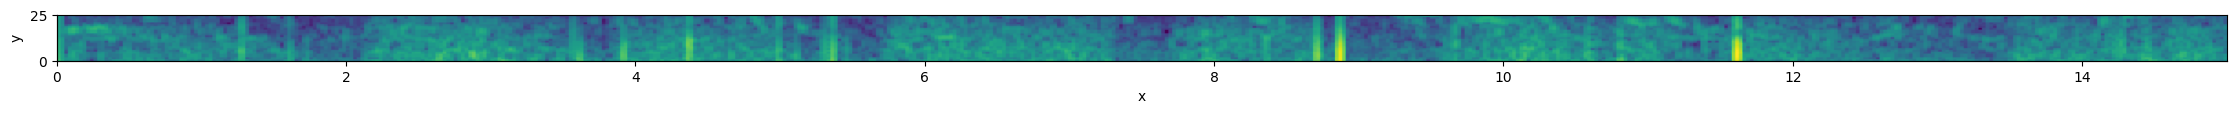

In [11]:
im_dif = cv2.imread(path+"normal04_Ch0_mel_spec.png")
im_gray = cv2.cvtColor(im_dif, cv2.COLOR_BGR2GRAY)
im_cut = im_gray[128:257,:]
ex = im_cut[90:115,0:1187]
#ex = im_cut[90:115,:]
ex = ex.astype(np.float32)

extent = (0, 15, 0, 25)
fig, ax = plt.subplots(figsize=(28, 8))
ax.imshow(ex)
ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
ax, secax_x, secax_y = secondary_axis(ex, ax, extent, 'bottom', 'left')
secax_x.set_xlabel('x')
secax_y.set_ylabel('y')
plt.show()

## 音声ファイルプロット

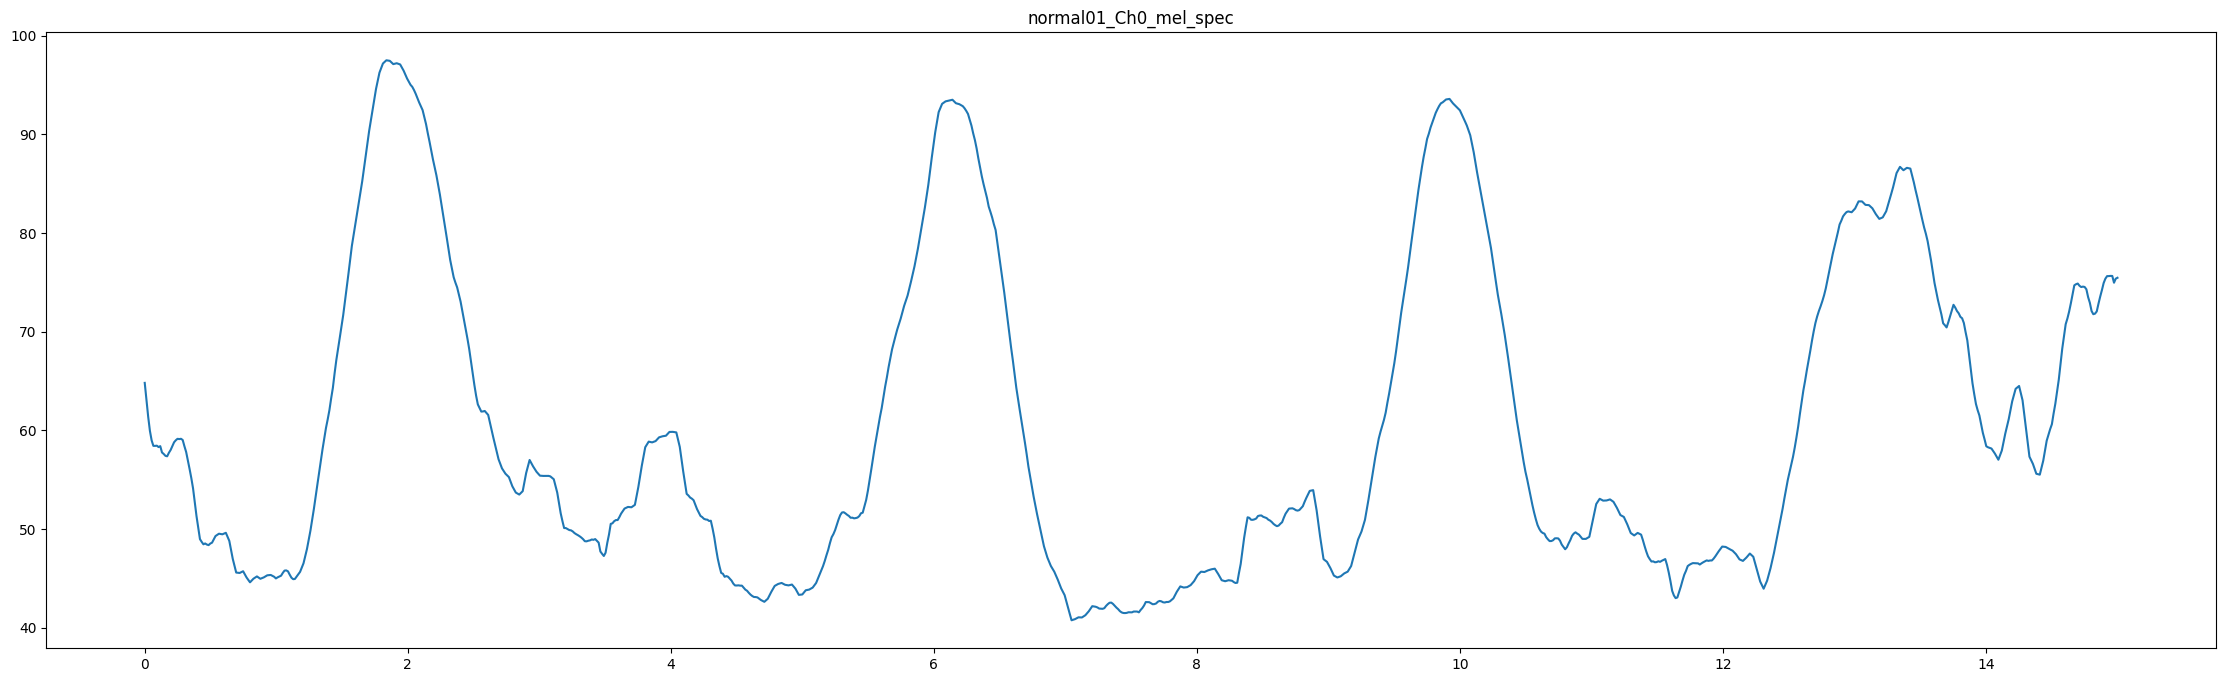

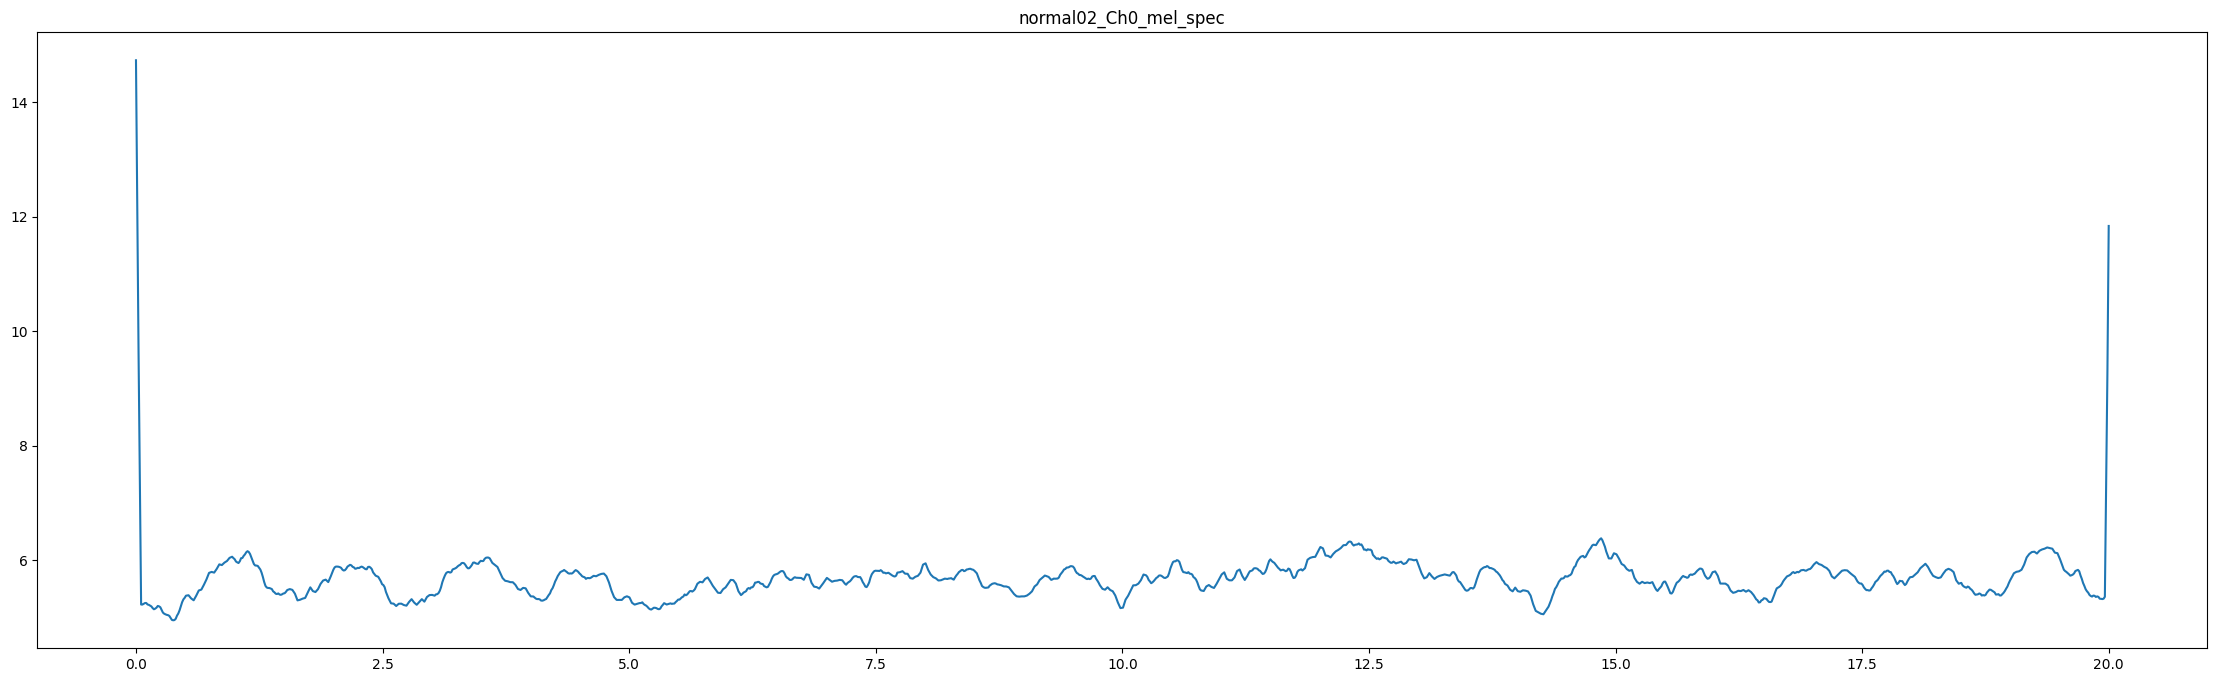

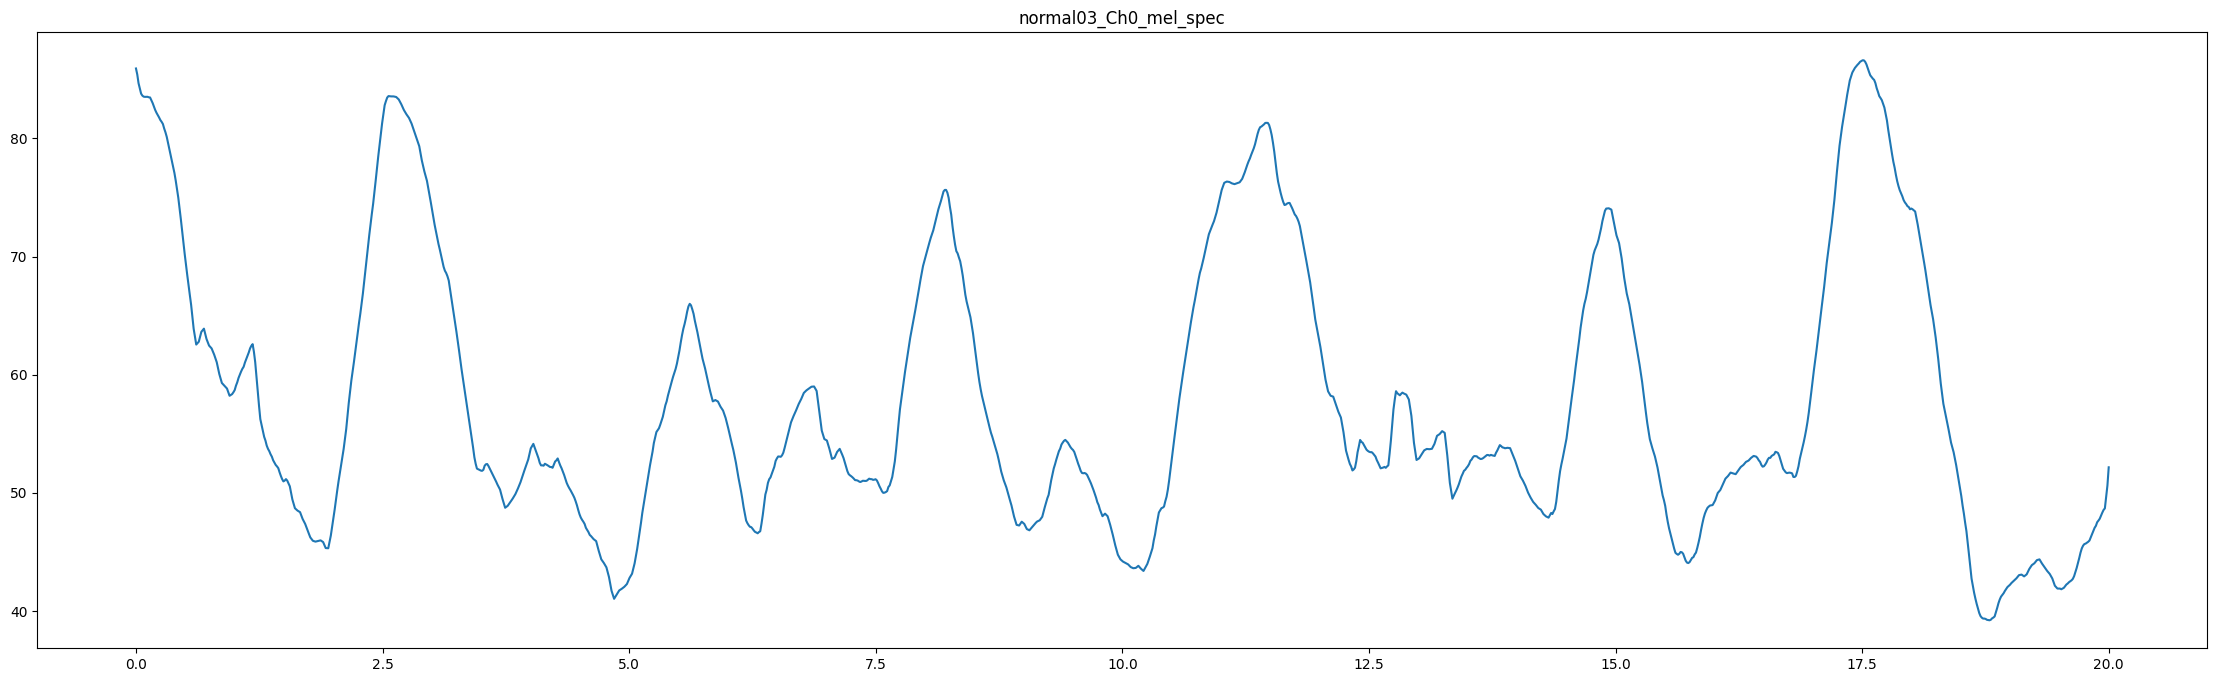

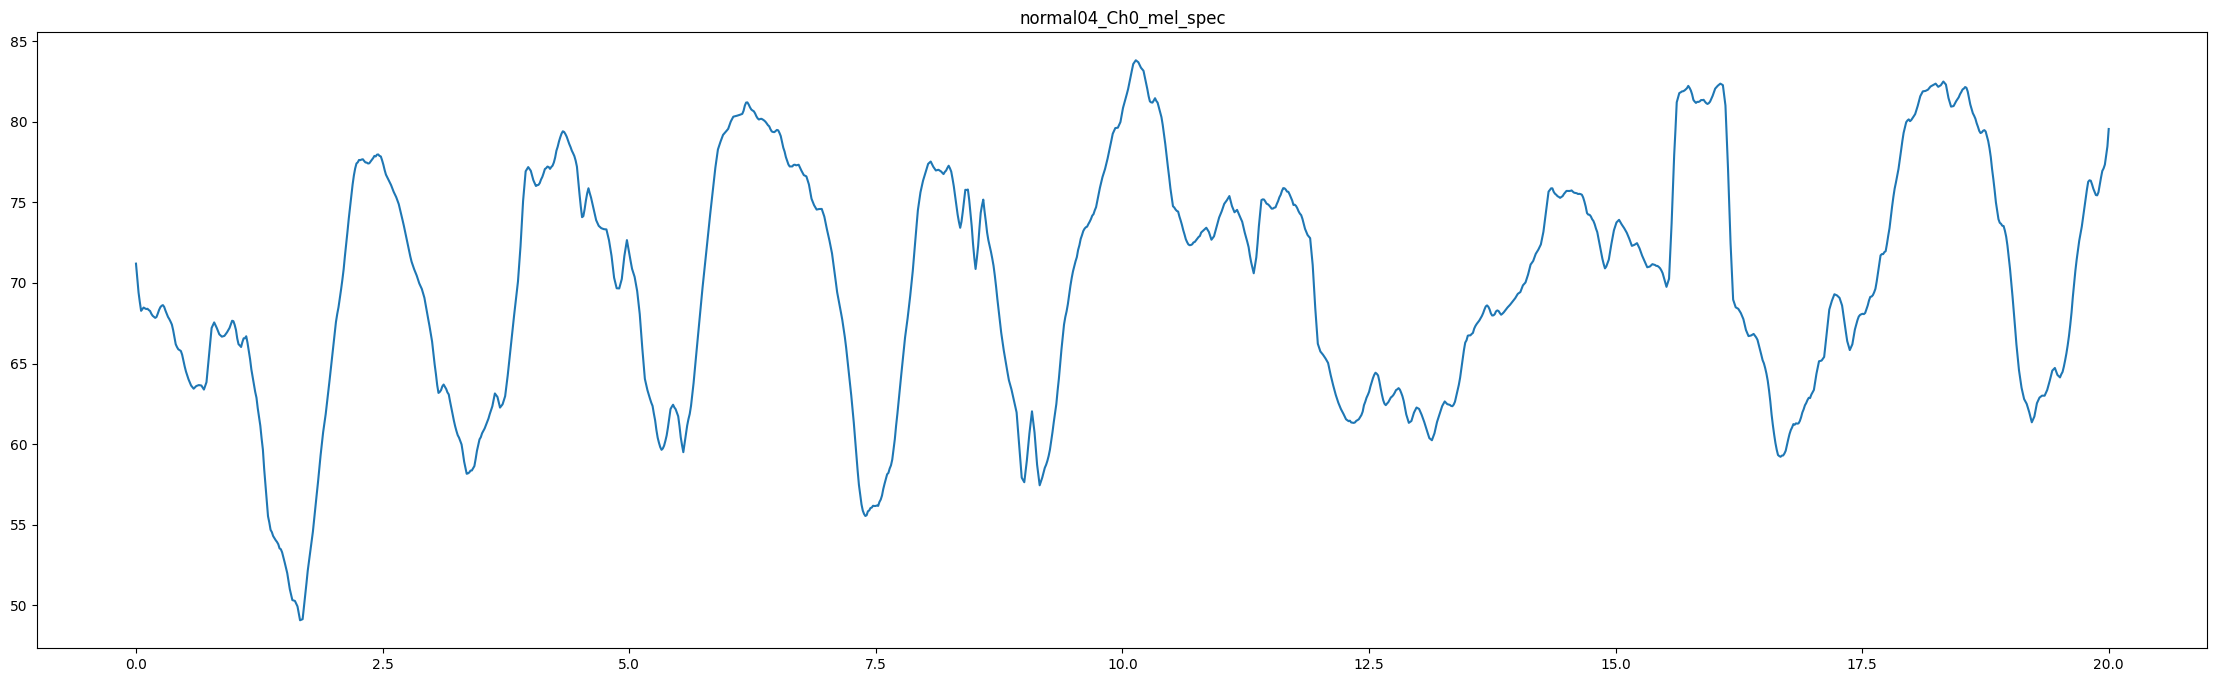

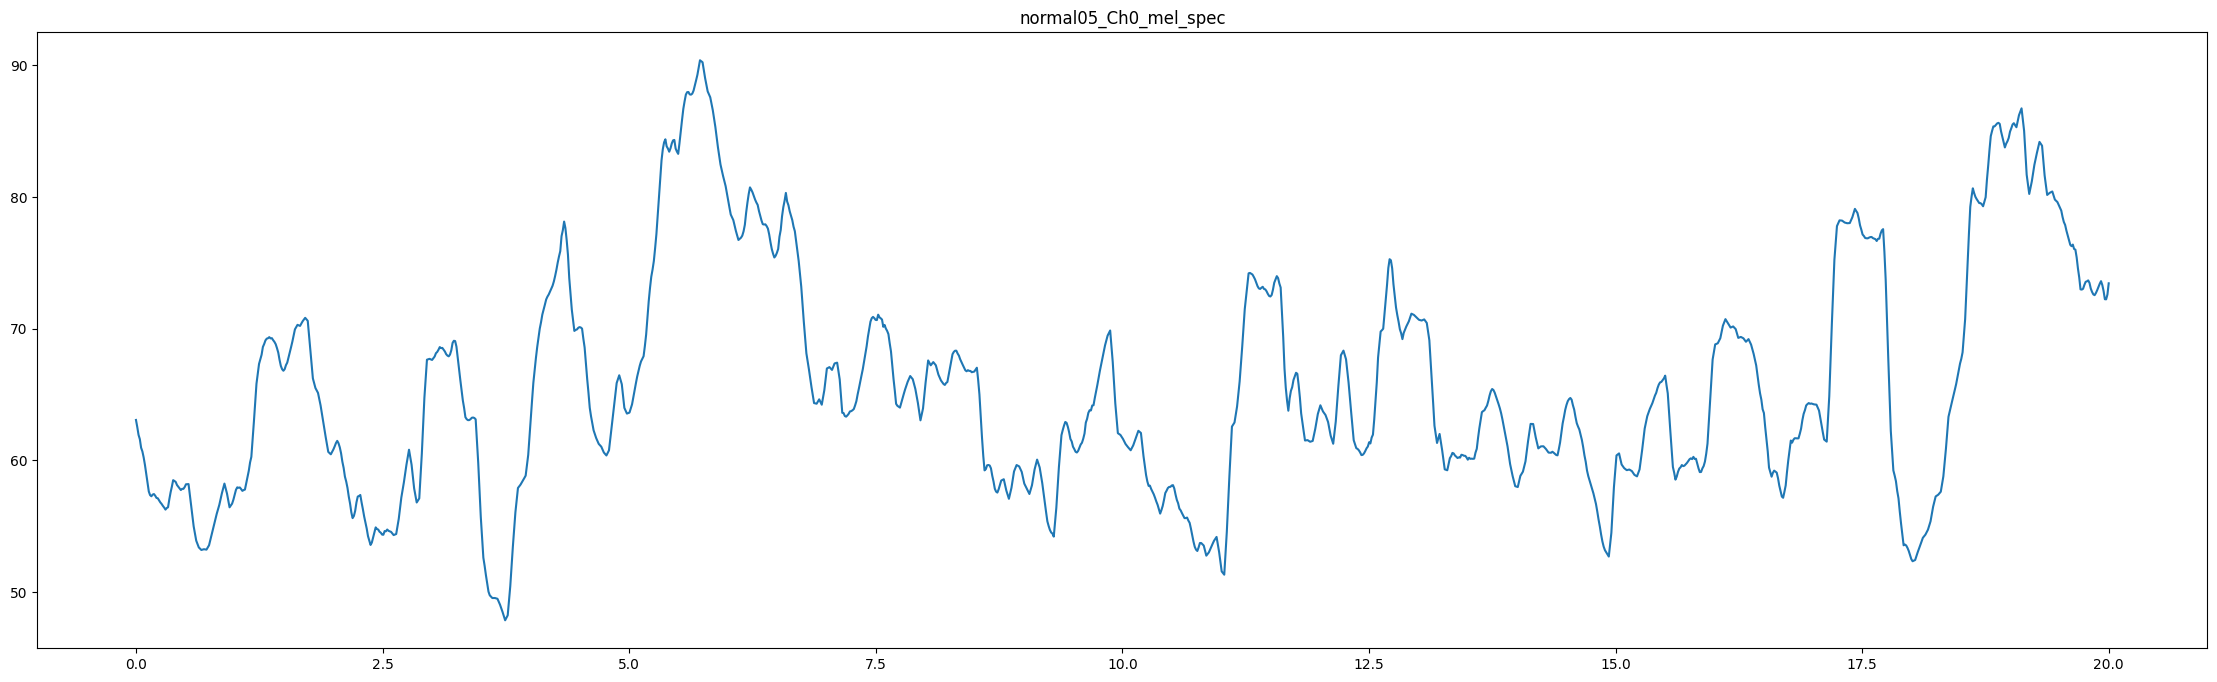

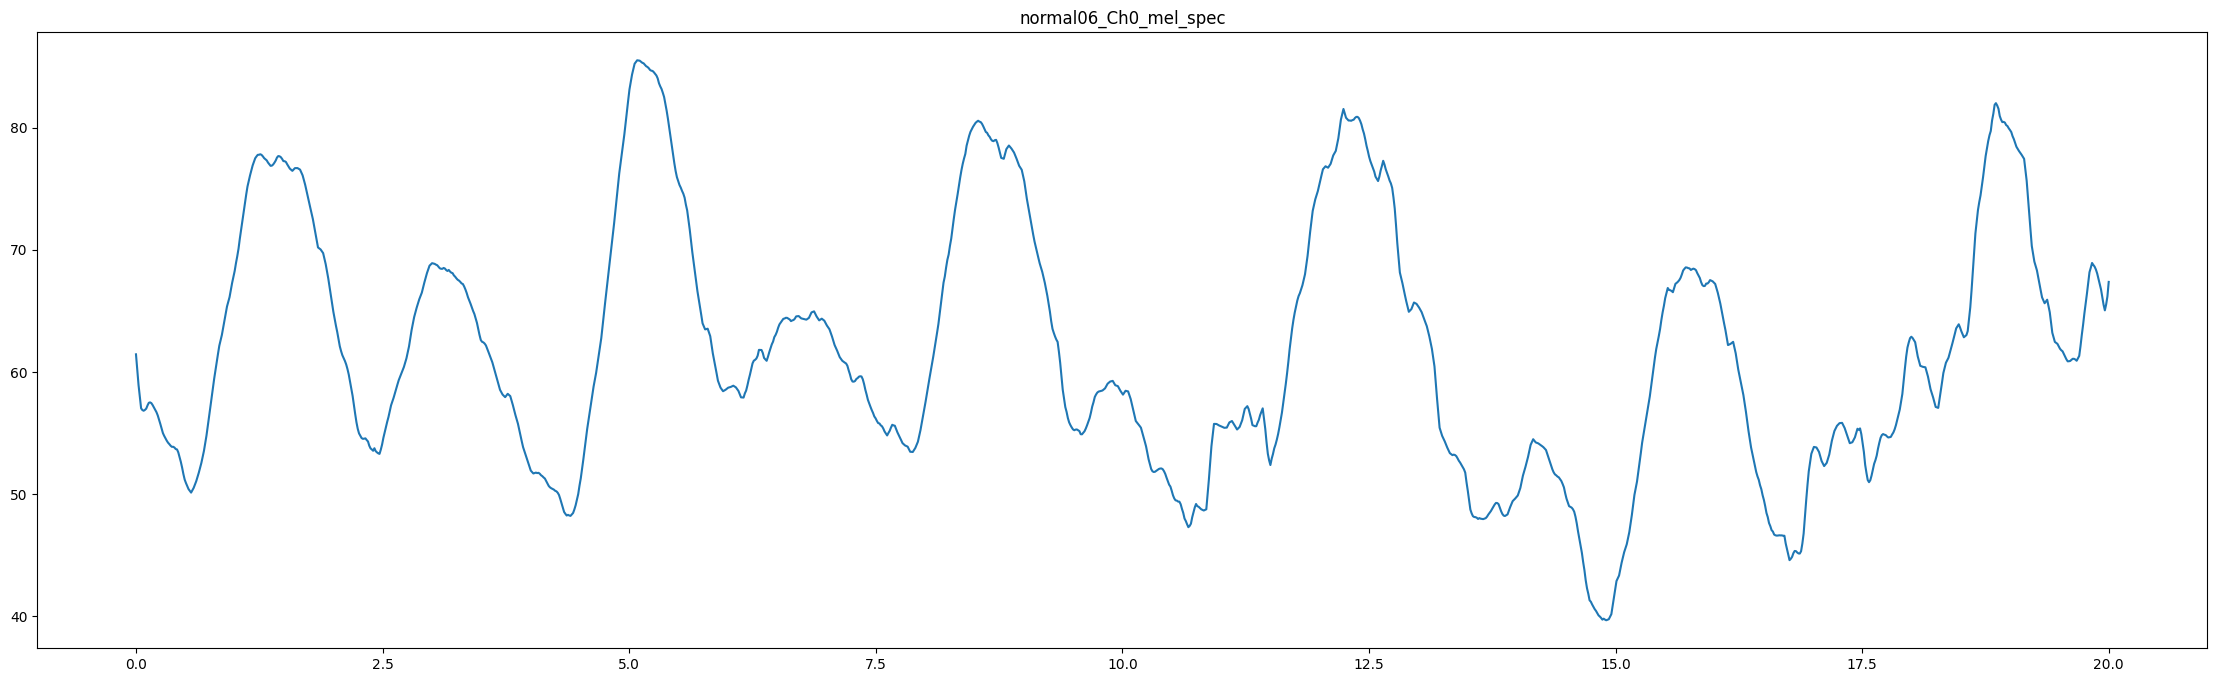

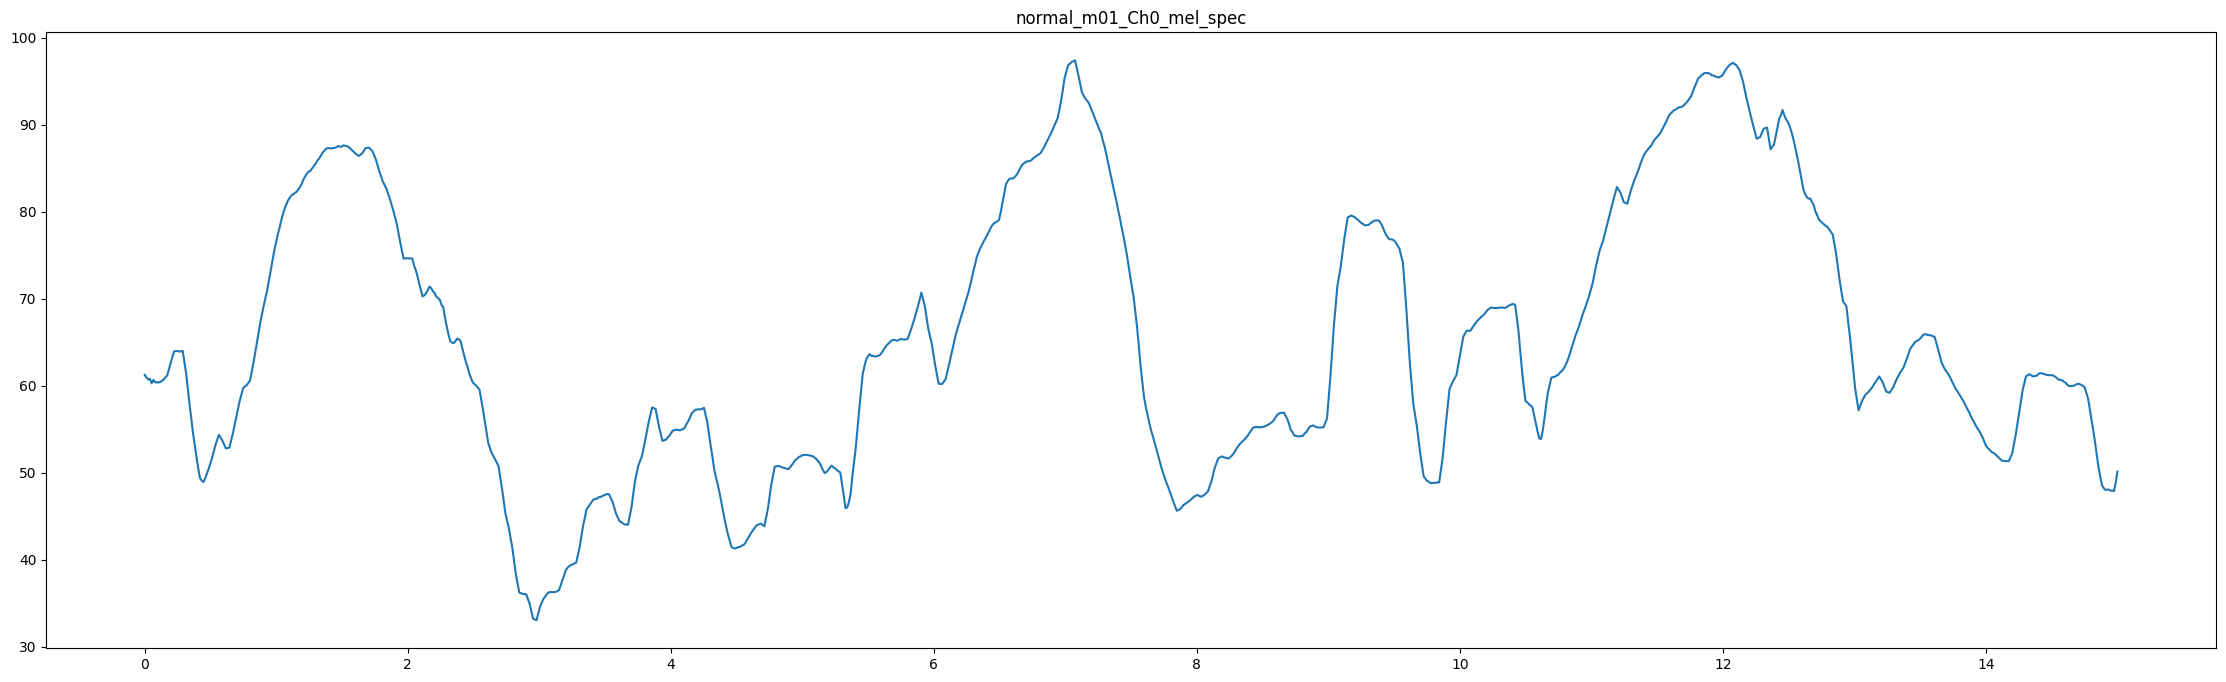

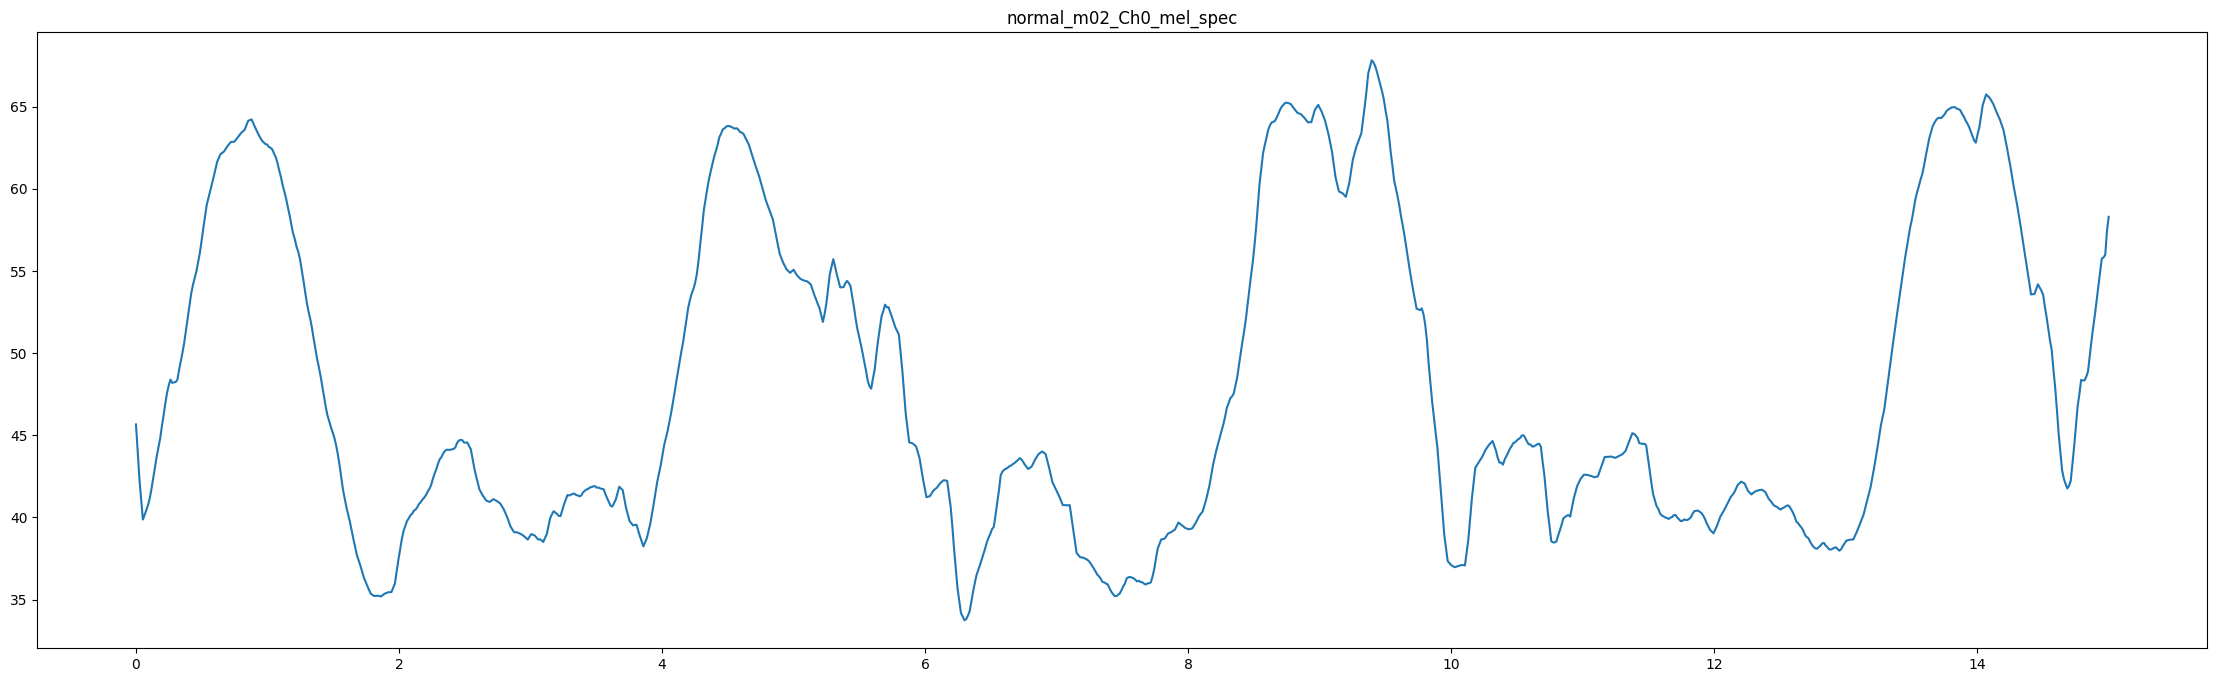

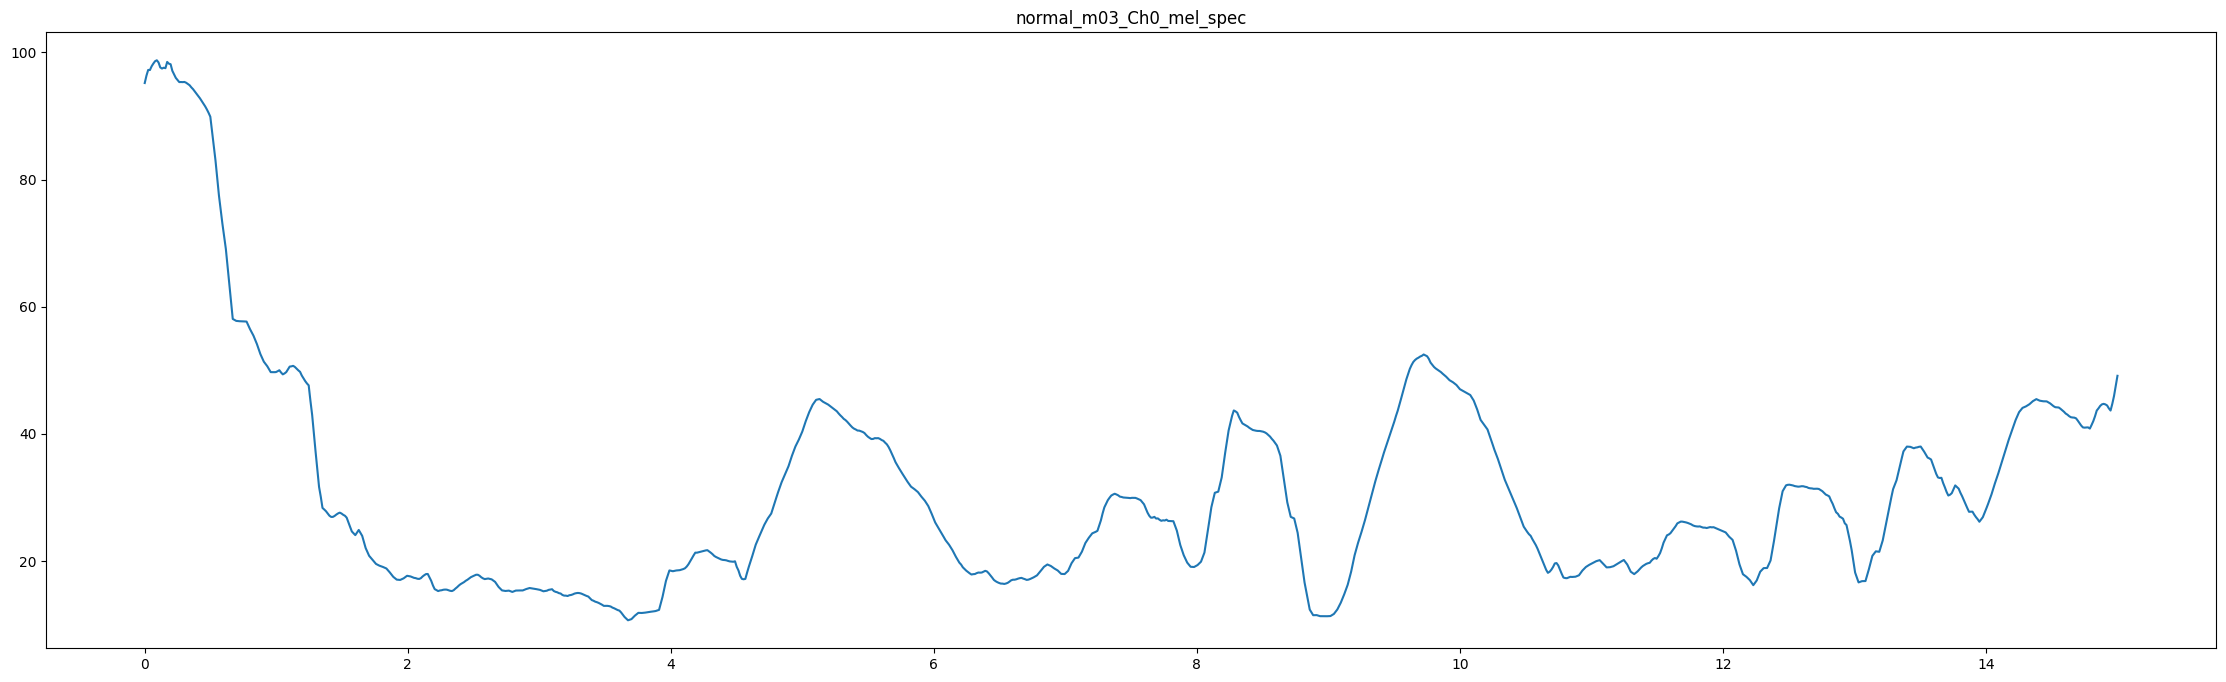

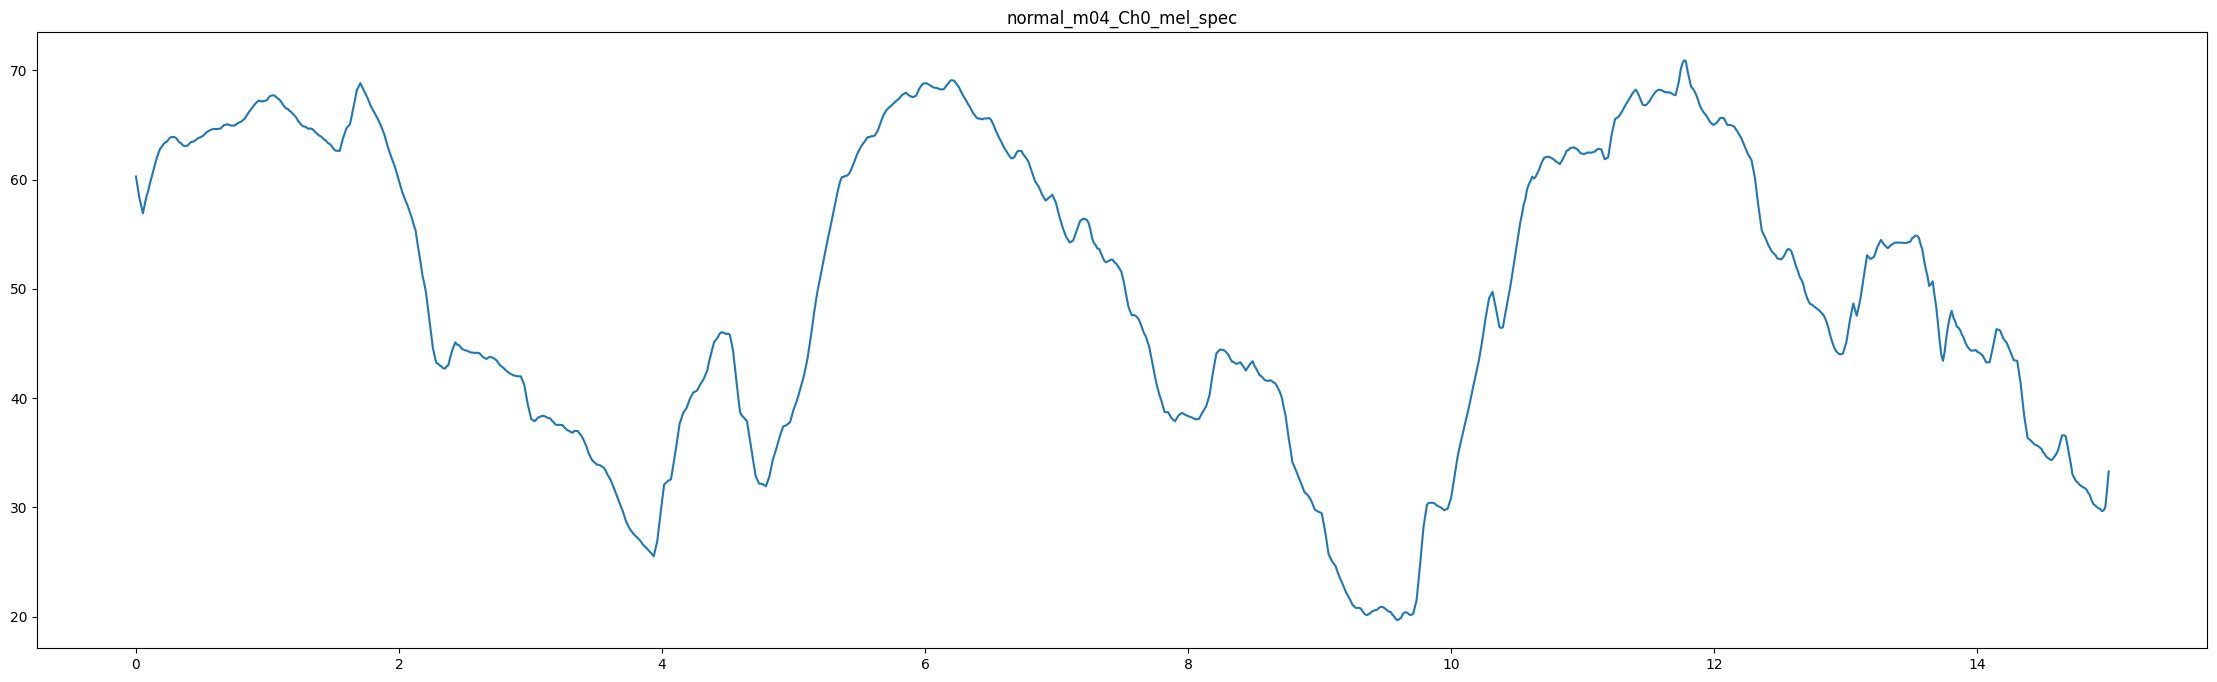

In [12]:
spec_wave_list = []
spec_wave_time = []
fs_spec_list = []


for j,i in enumerate(wav_files):
    
    low_wave_list = []
    
    im_dif = cv2.imread(path+i[0:-4]+file+".png")
    im_gray = cv2.cvtColor(im_dif, cv2.COLOR_BGR2GRAY)
    im_cut = im_gray[128:257,:]
    ex = im_cut[80:110,:]#115
    ex = ex.astype(np.float32)
    
    #print(test_wave_time[j][-1])
    if test_wave_time[j][-1]==15.0:
        N_spec = 150000#ex.shape[0] # 標本データ数(要素数)を返す
        L_spec = 15.0#test_wave_time[j][-1] # 時間(長さ)の算出
        spec_time_axis = np.linspace(0, 15.0, int(15/(20.0/1584)))
        #ex = ex[0:int(15/(20.0/1584))]
        for t in range(int(15/(20.0/1584))-44):
            win = ex[:,t:t+44]
            low_wave_list.append(np.mean(win,axis=None))
            x = np.linspace(0, L_spec, int(15/(20.0/1584))-44)
        
    elif test_wave_time[j][-1]==20.0:
        N_spec = 200000#ex.shape[0] # 標本データ数(要素数)を返す
        L_spec = 20.0#test_wave_time[j][-1] # 時間(長さ)の算出
        spec_time_axis = np.linspace(0, 20.0, 1584)
        for t in range(int(20/(20.0/1584))-44):
            win = ex[:,t:t+44]
            low_wave_list.append(np.mean(win,axis=None))
            x = np.linspace(0, L_spec, int(20/(20.0/1584))-44)
    
    fs_spec = 1/(L_spec/N_spec)
    
    spec_wave_list.append(low_wave_list)
    spec_wave_time.append(x)
    fs_spec_list.append(fs_spec)
    
    fig, ax = plt.subplots(figsize=(28, 8))
    ax.set_title(i[0:-4]+file)
    plt.plot(x,low_wave_list)

In [13]:
x[1]*32

0.4199475065616798

## 低周波数のrms信号算出

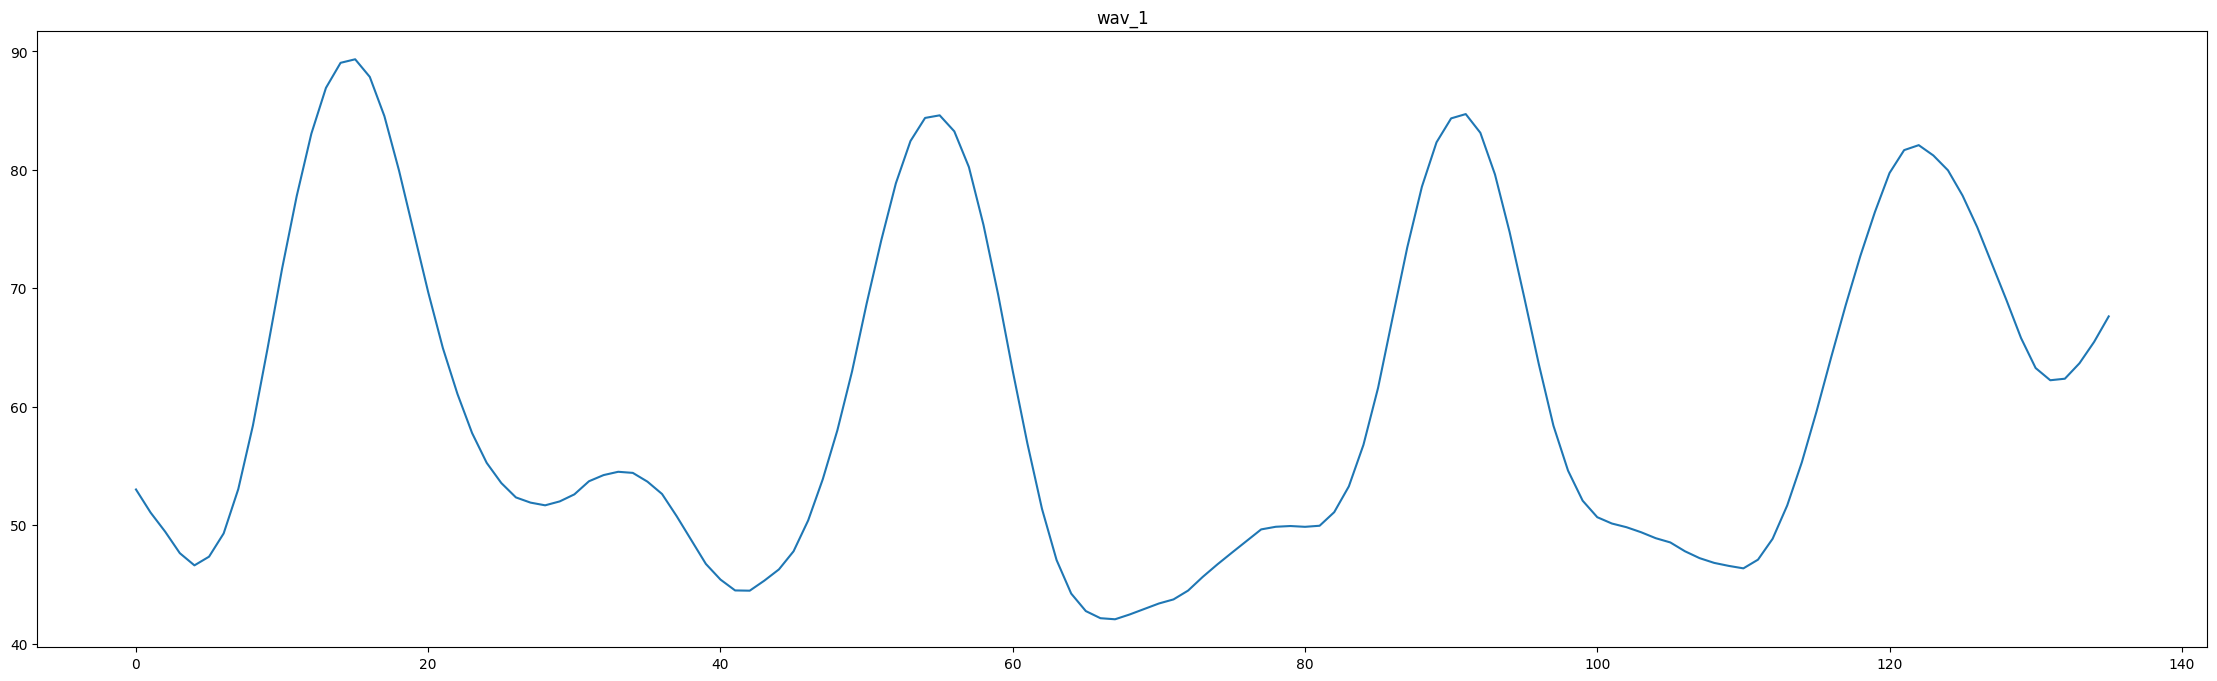

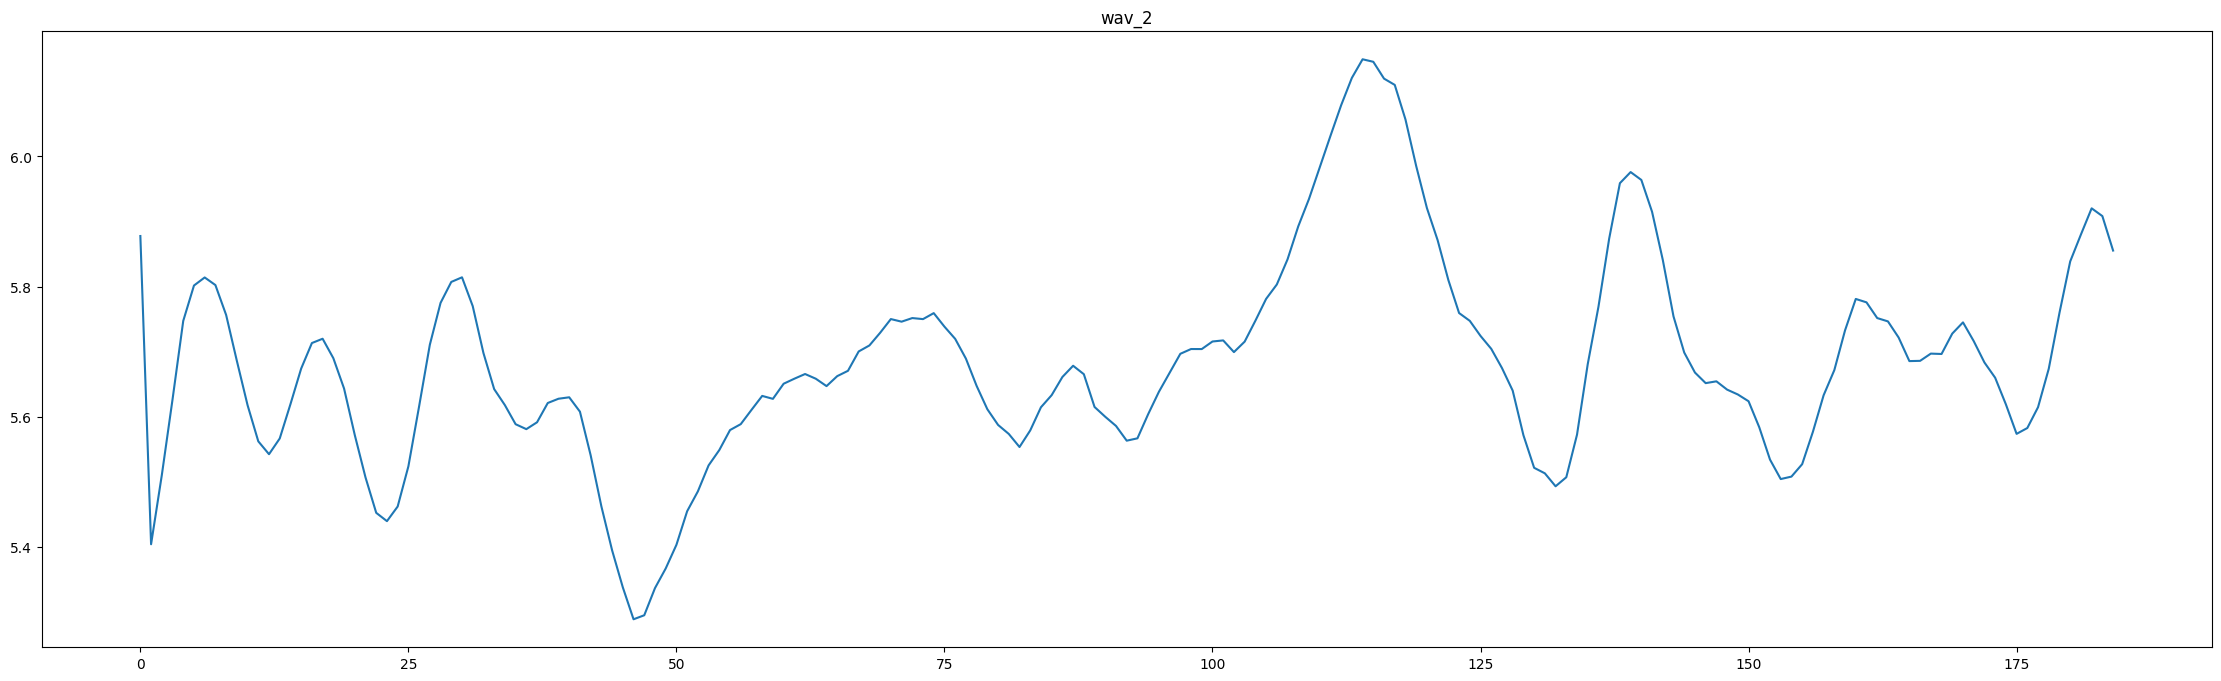

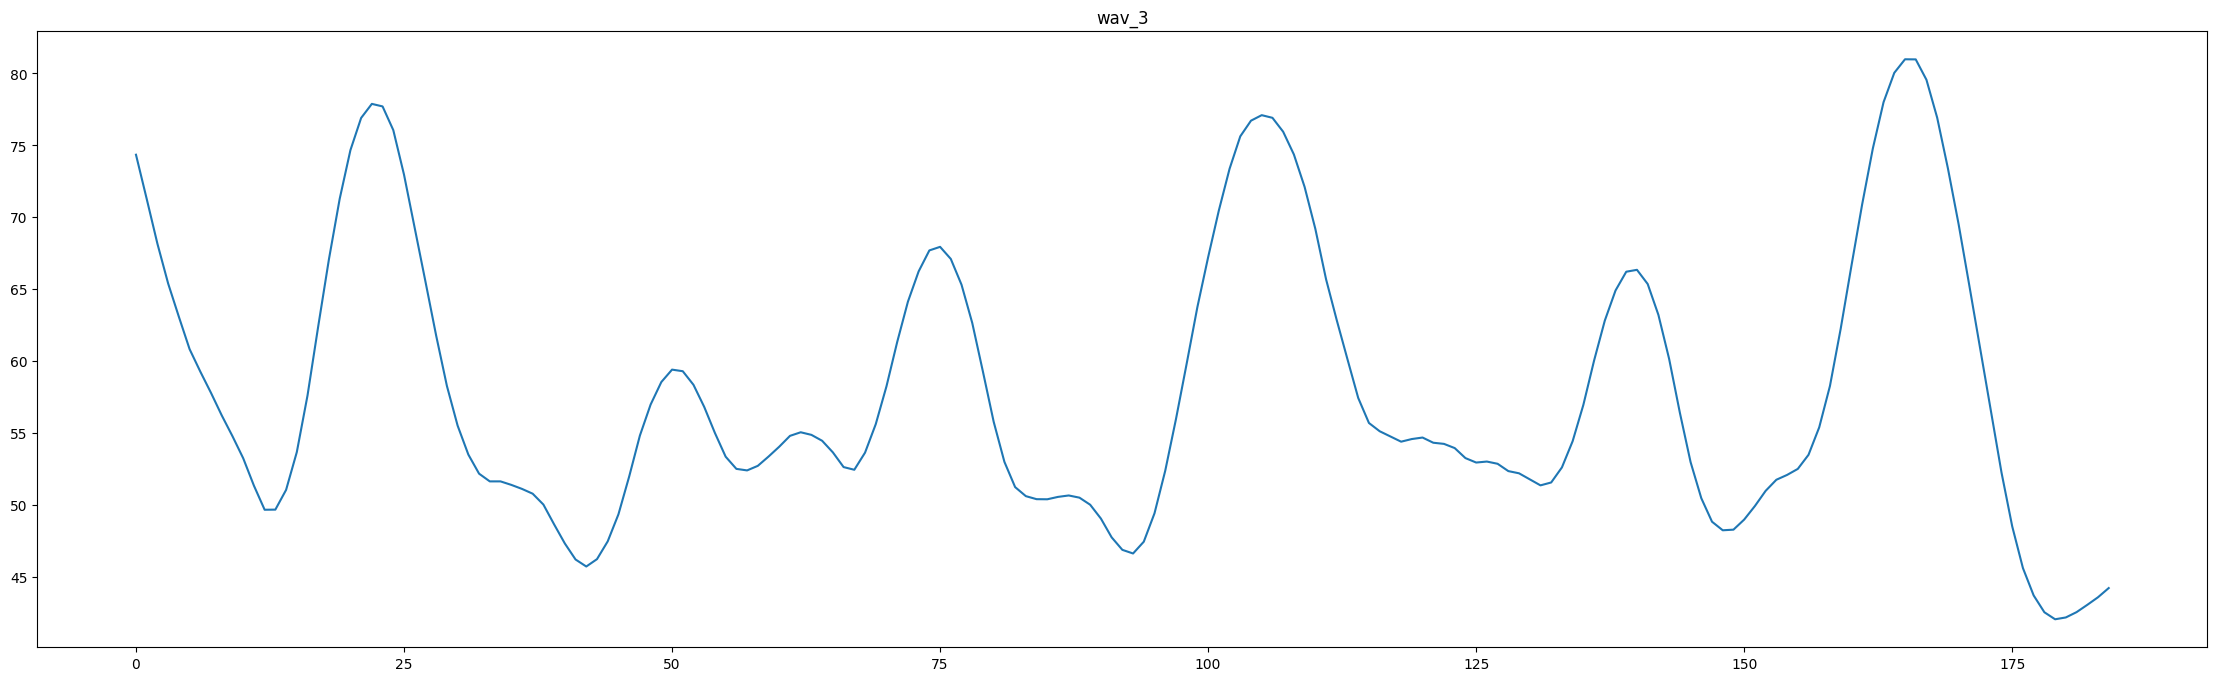

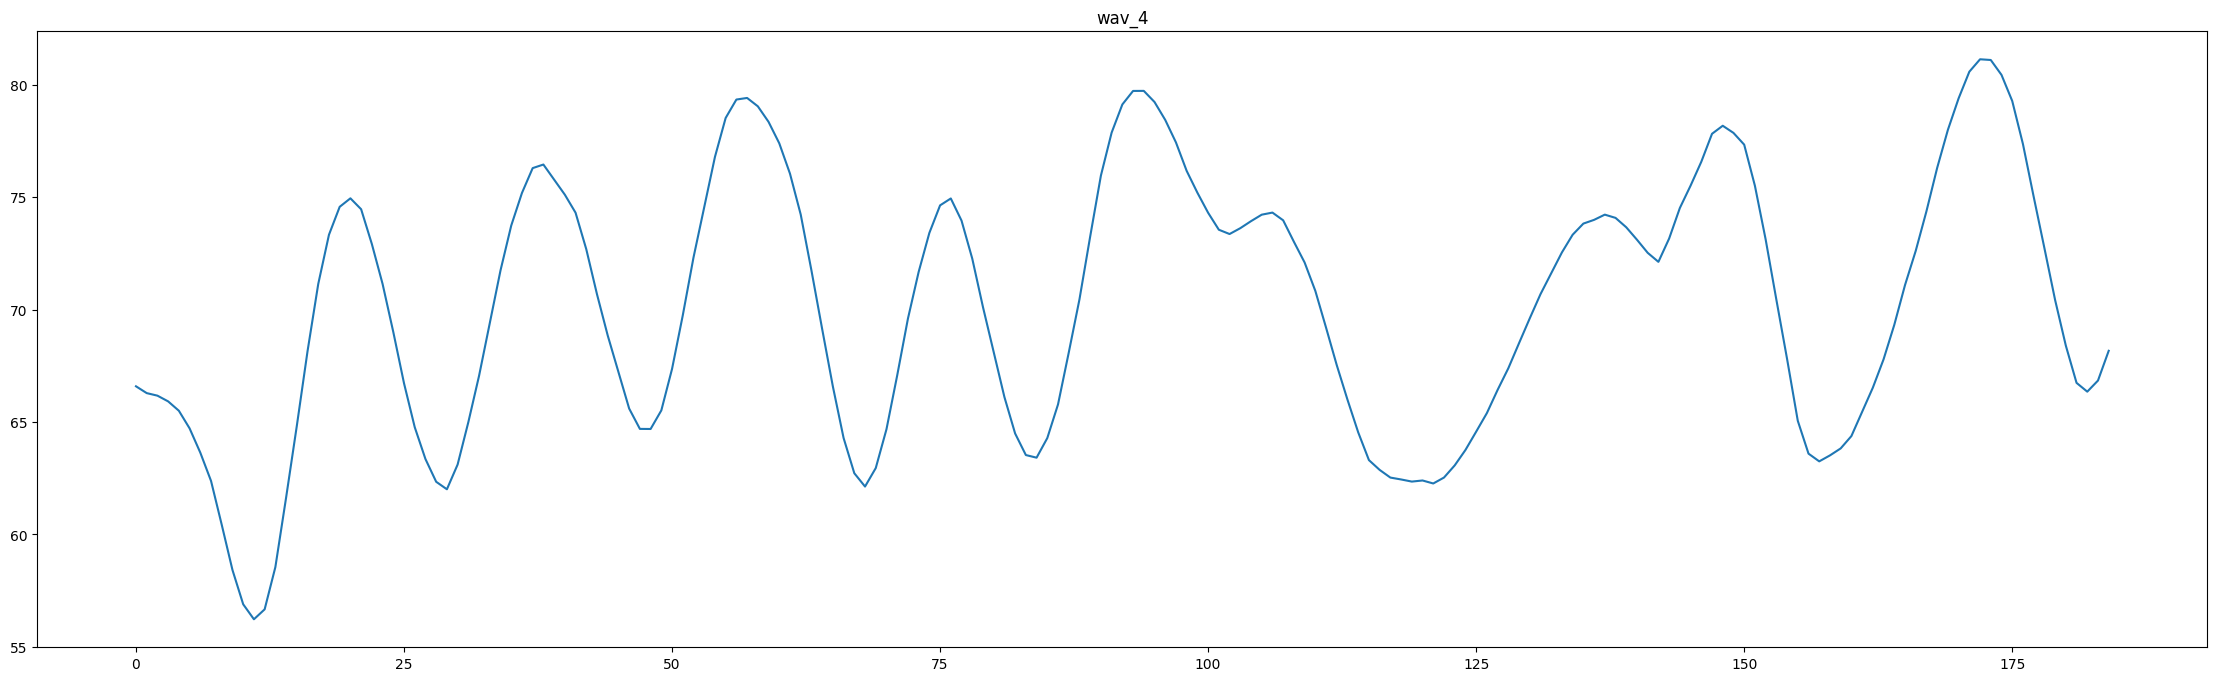

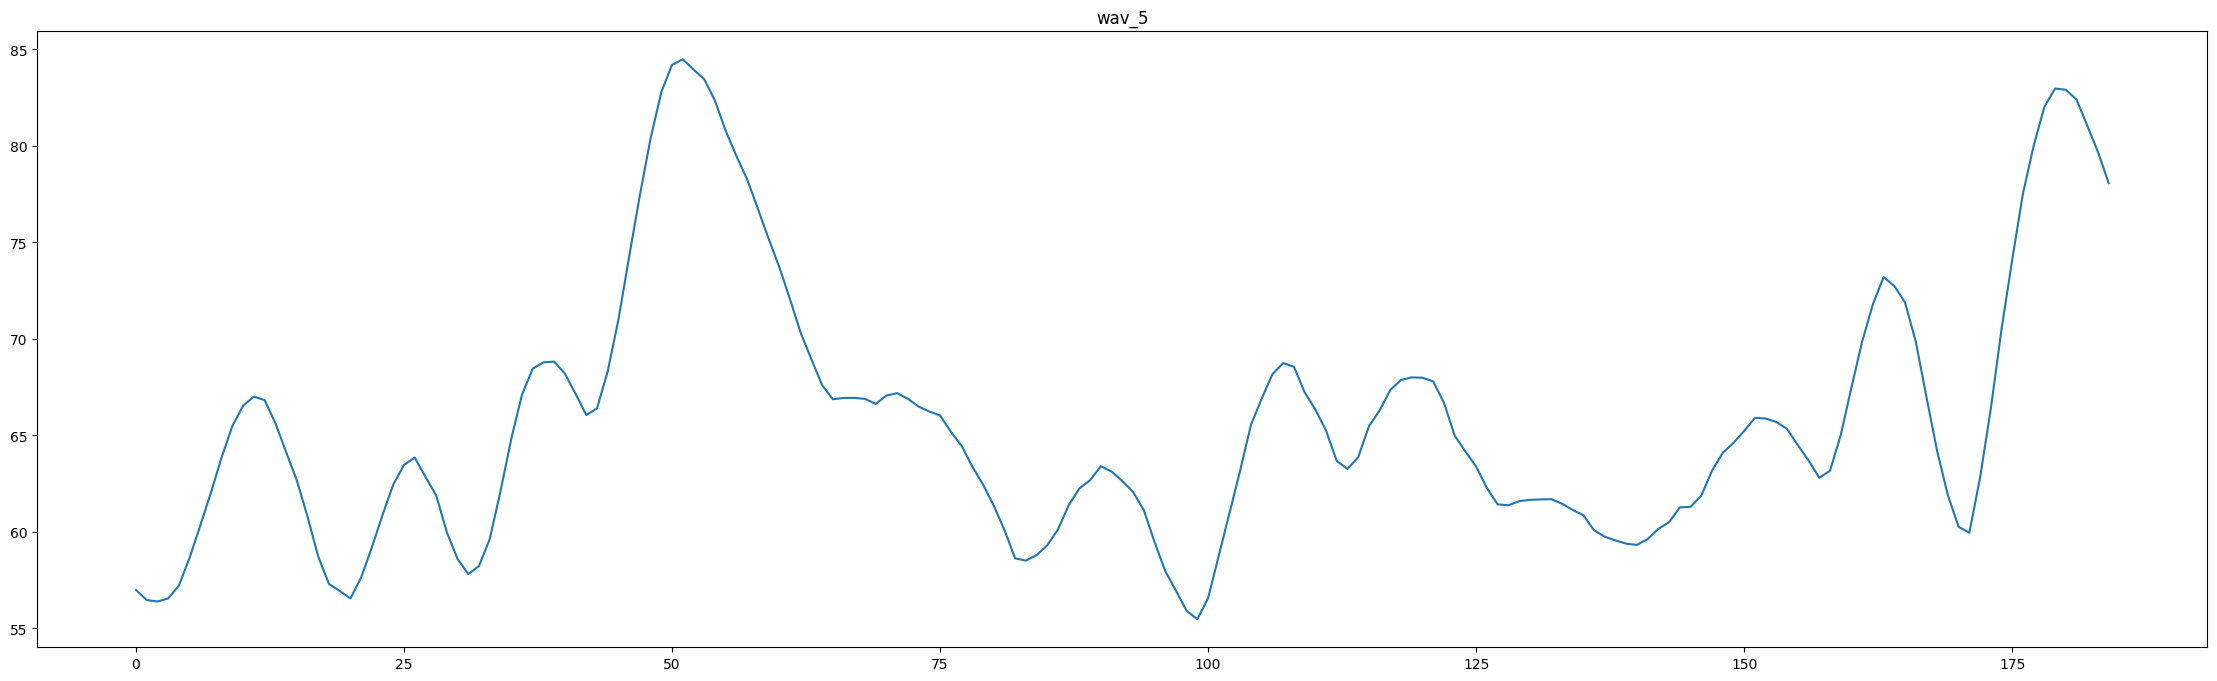

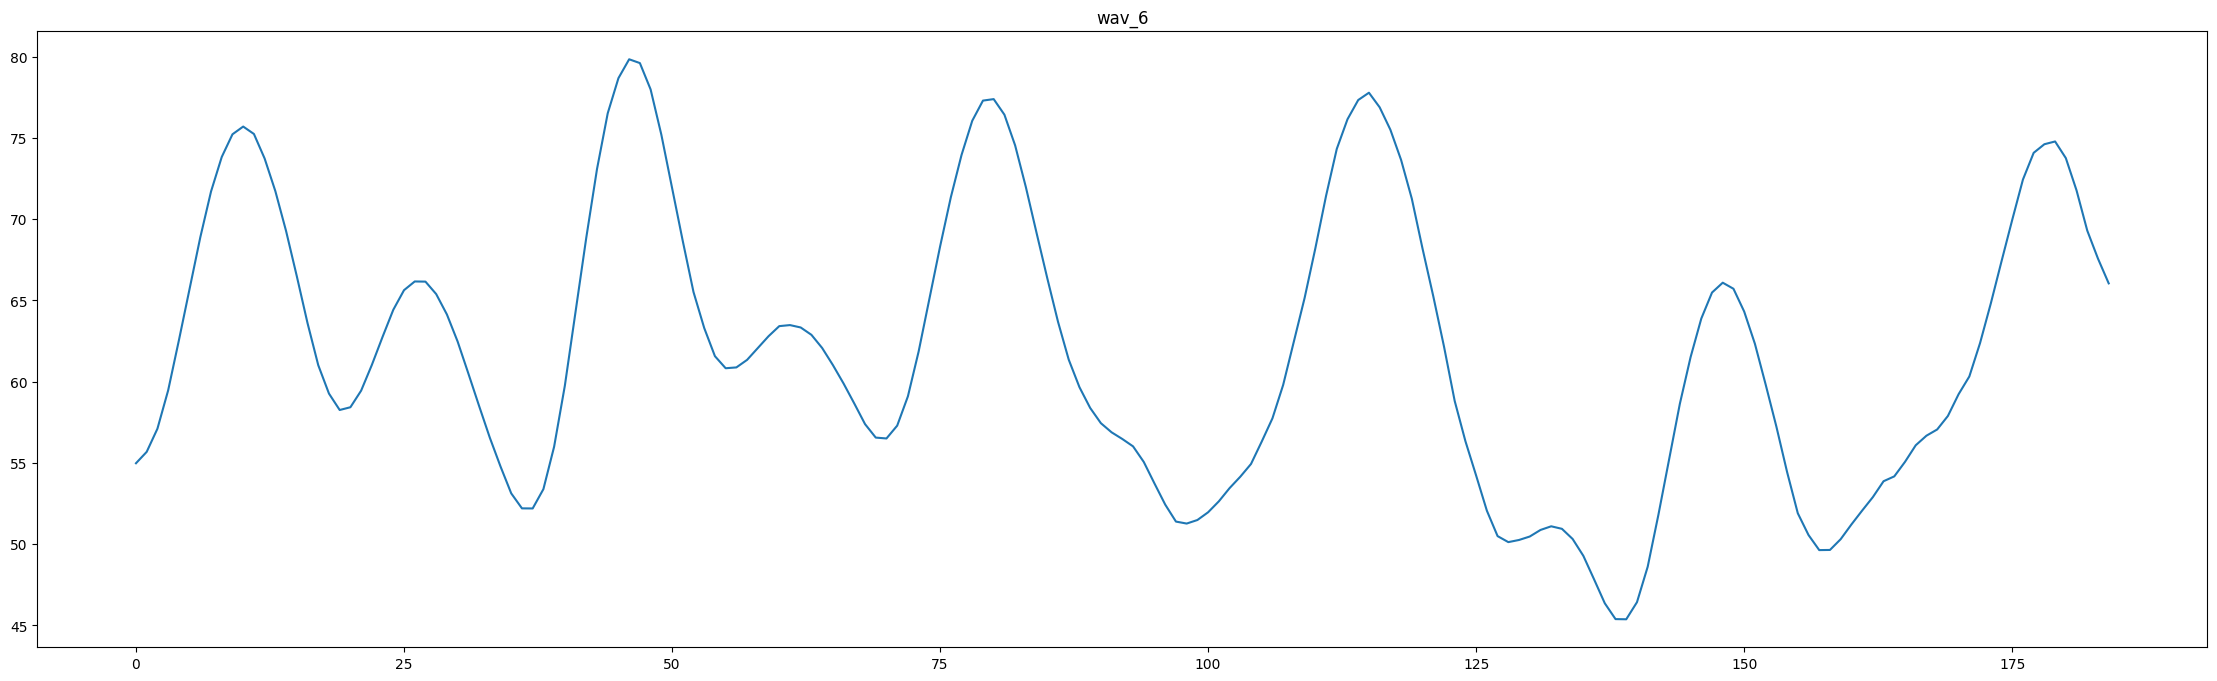

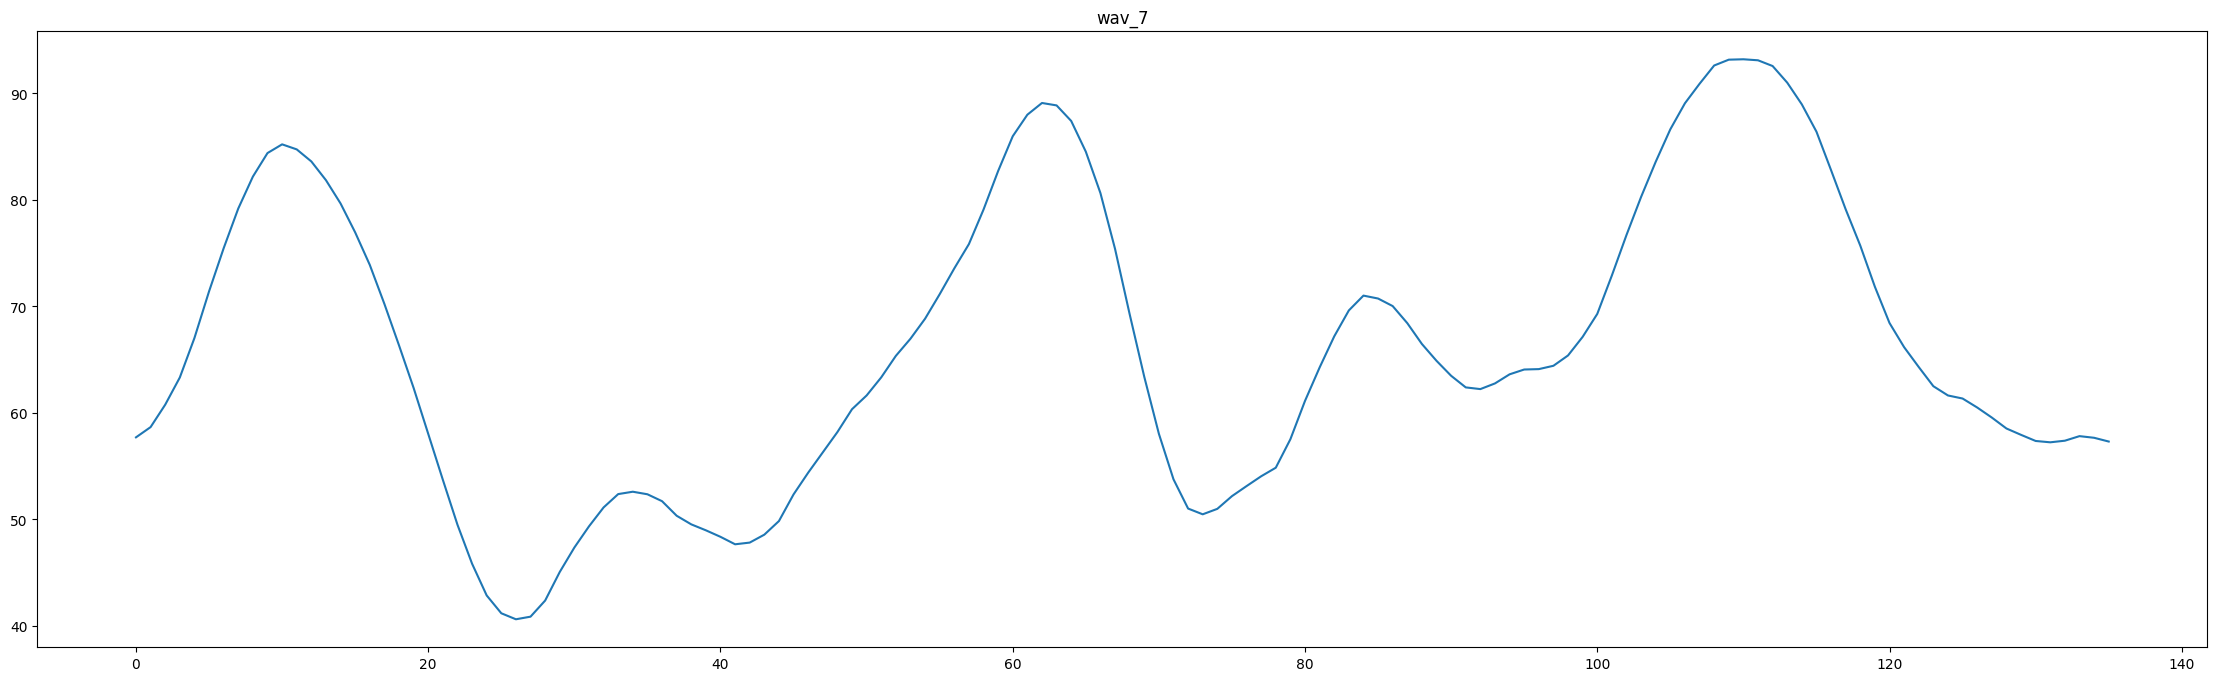

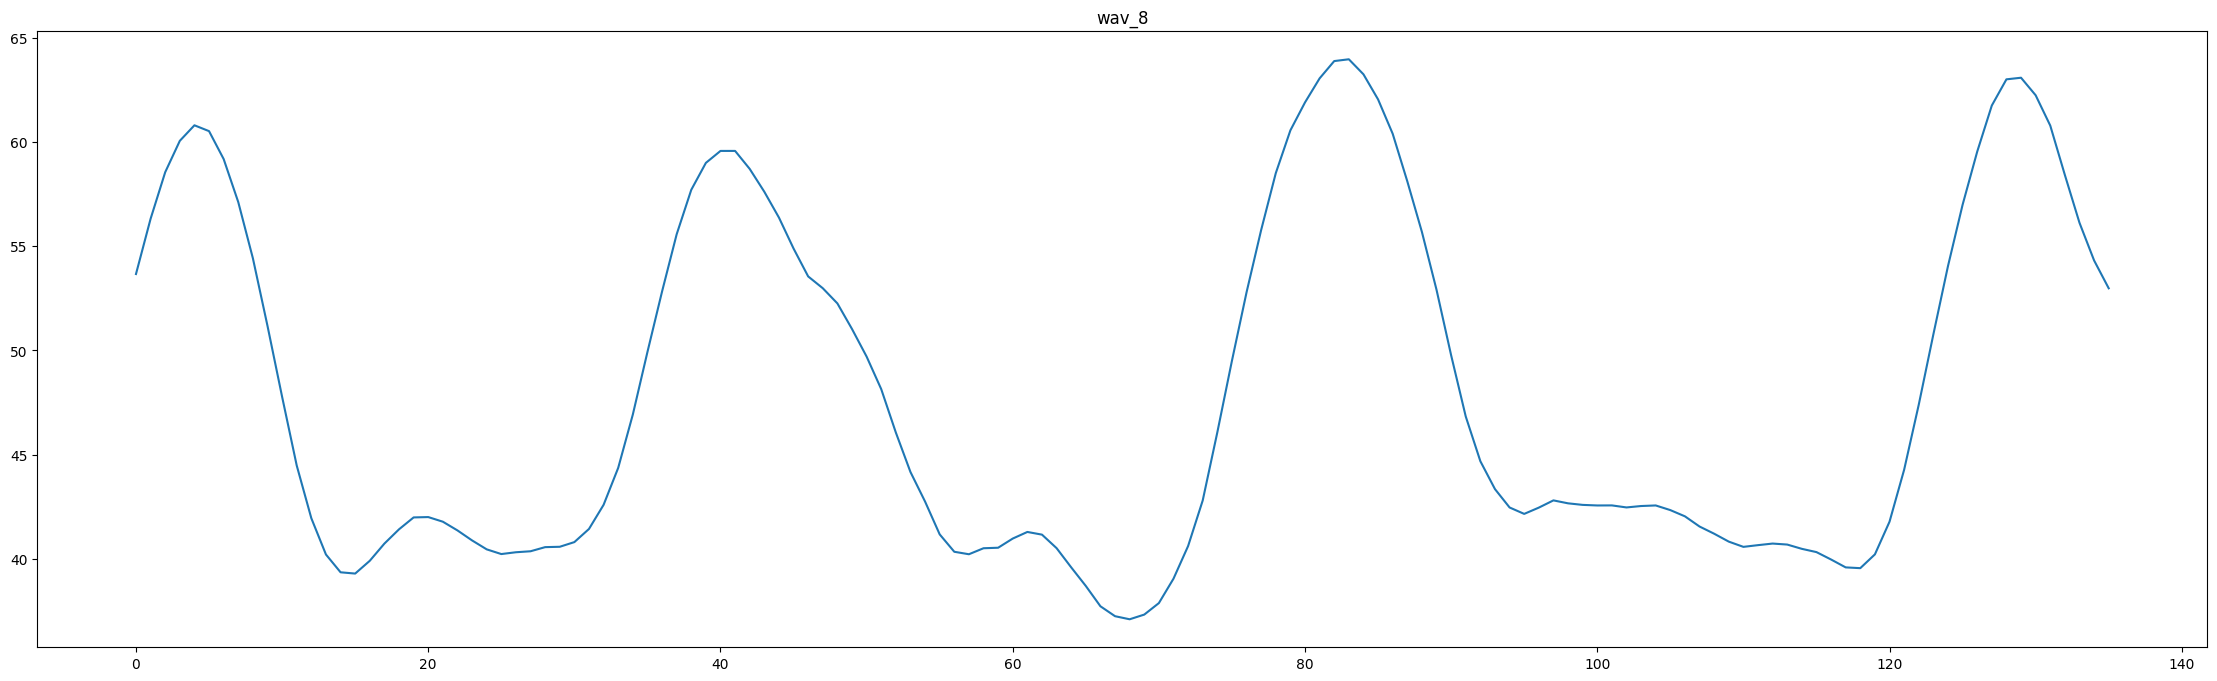

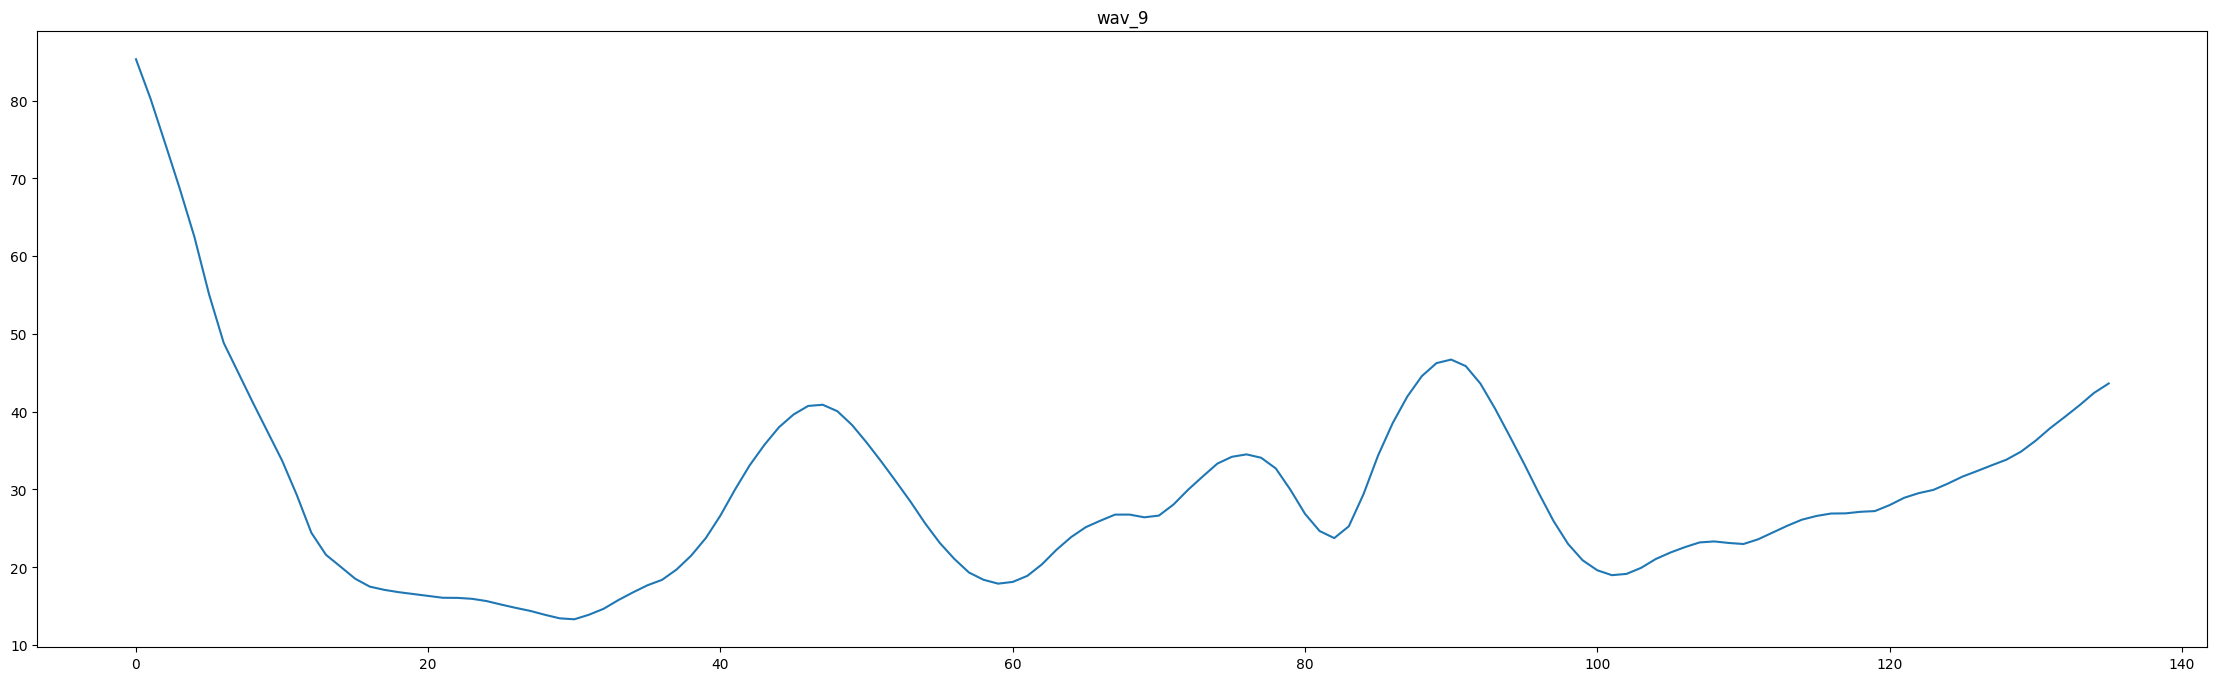

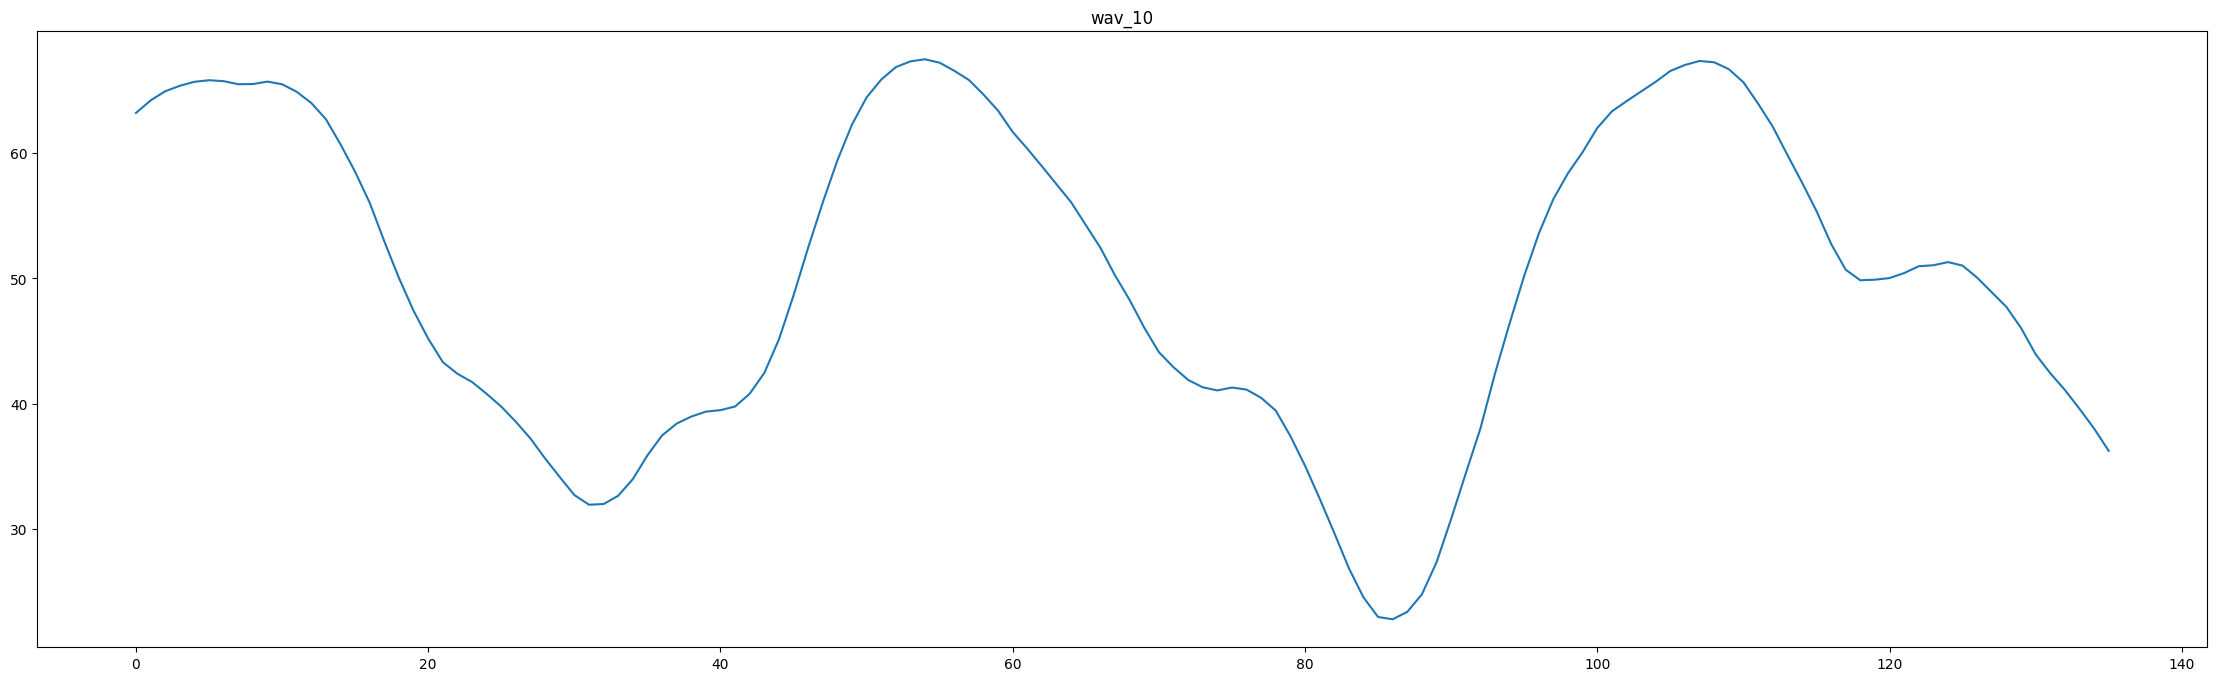

In [14]:
rms_wave_list = []
rms_time_list = []
fs_rms_list = []

time_185 = np.linspace(0,20.0,185)
time_136 = np.linspace(0,15.0,136)

for j,i in enumerate(spec_wave_list):
    rms_wave = librosa.feature.rms(i, frame_length=64, hop_length=8, center=False)
    
    N_rms = len(rms_wave.ravel()) # 標本データ数(要素数)を返す
    L_rms = spec_wave_time[j][-1] # 時間(長さ)の算出
    x_rms = np.linspace(0, L_rms, N_rms)
    fs_rms = 1/(L_rms/N_rms)
    
    rms_wave_list.append(rms_wave.ravel())
    rms_time_list.append(x_rms)
    fs_rms_list.append(fs_rms)
    
    fig, ax = plt.subplots(figsize=(28, 8))
    
    '''
    if len(rms_wave.ravel())==136:
        plt.plot(time_136, rms_wave.ravel())
        plt.xticks(np.arange(0, 15.0, 0.5))
    elif len(rms_wave.ravel())==185:
        plt.plot(time_185, rms_wave.ravel())
        plt.xticks(np.arange(0, 20.0, 0.5))
    '''
    plt.plot(rms_wave.ravel())
    ax.set_title(j)
    #ax.set_xticks(np.arange(0, plot_time[-1], 0.5))
    plt.title("wav_"+str(j+1))
    plt.show()

## 平均差分信号算出

136
185
185
185
185
185
136
136
136
136


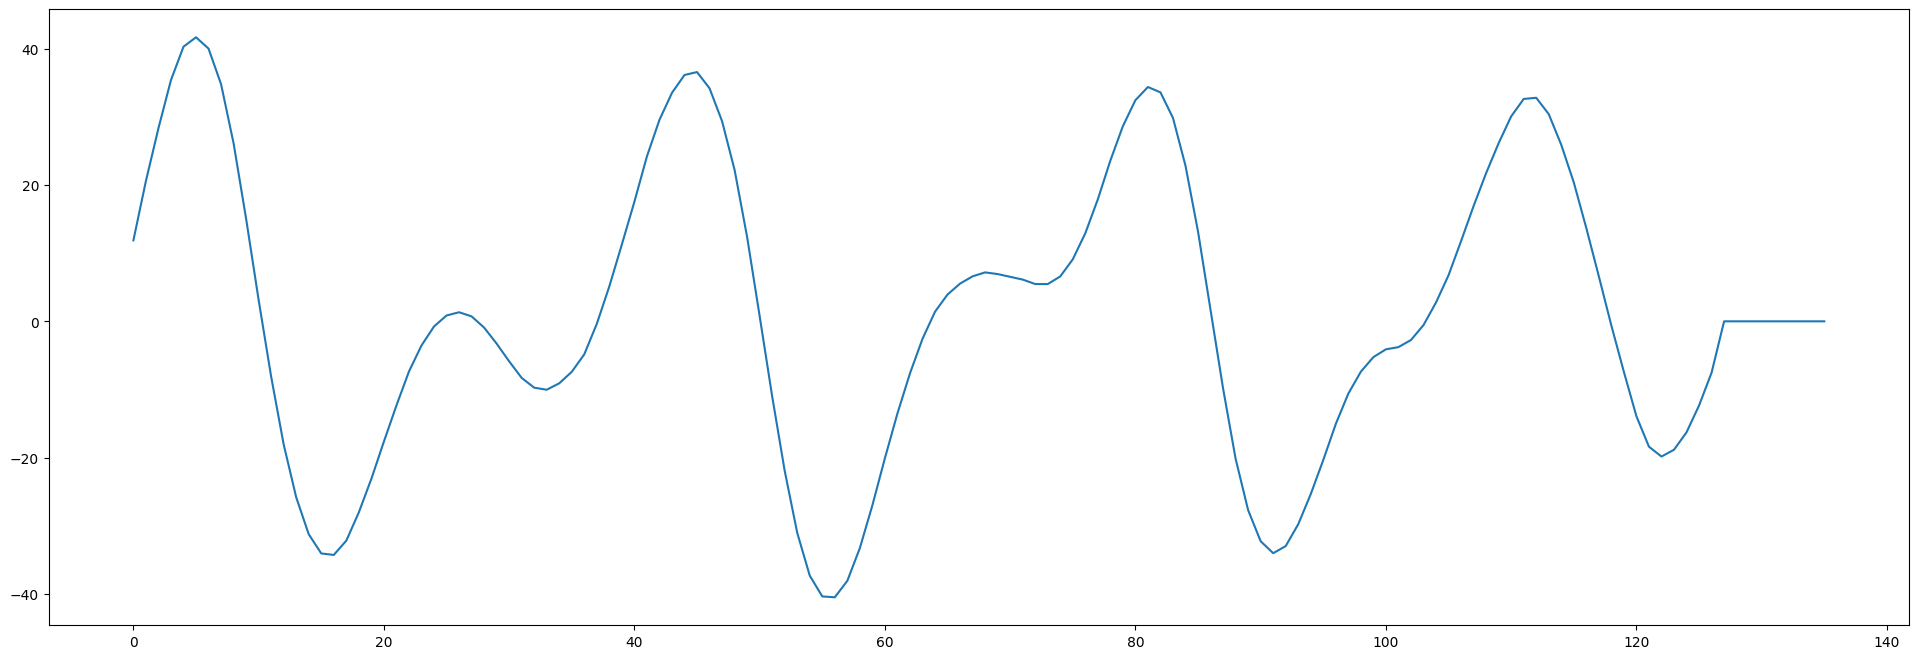

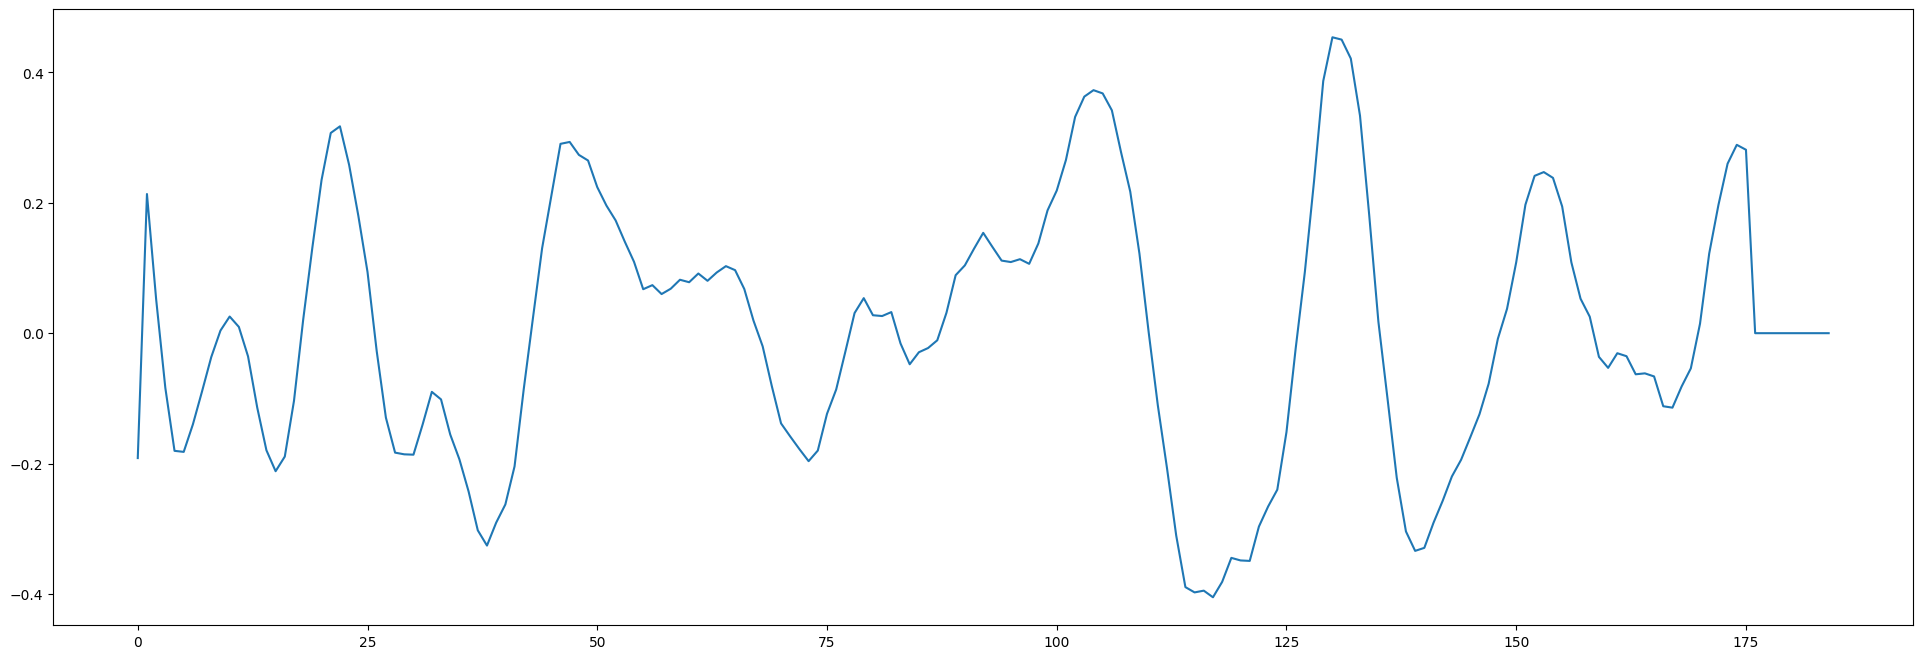

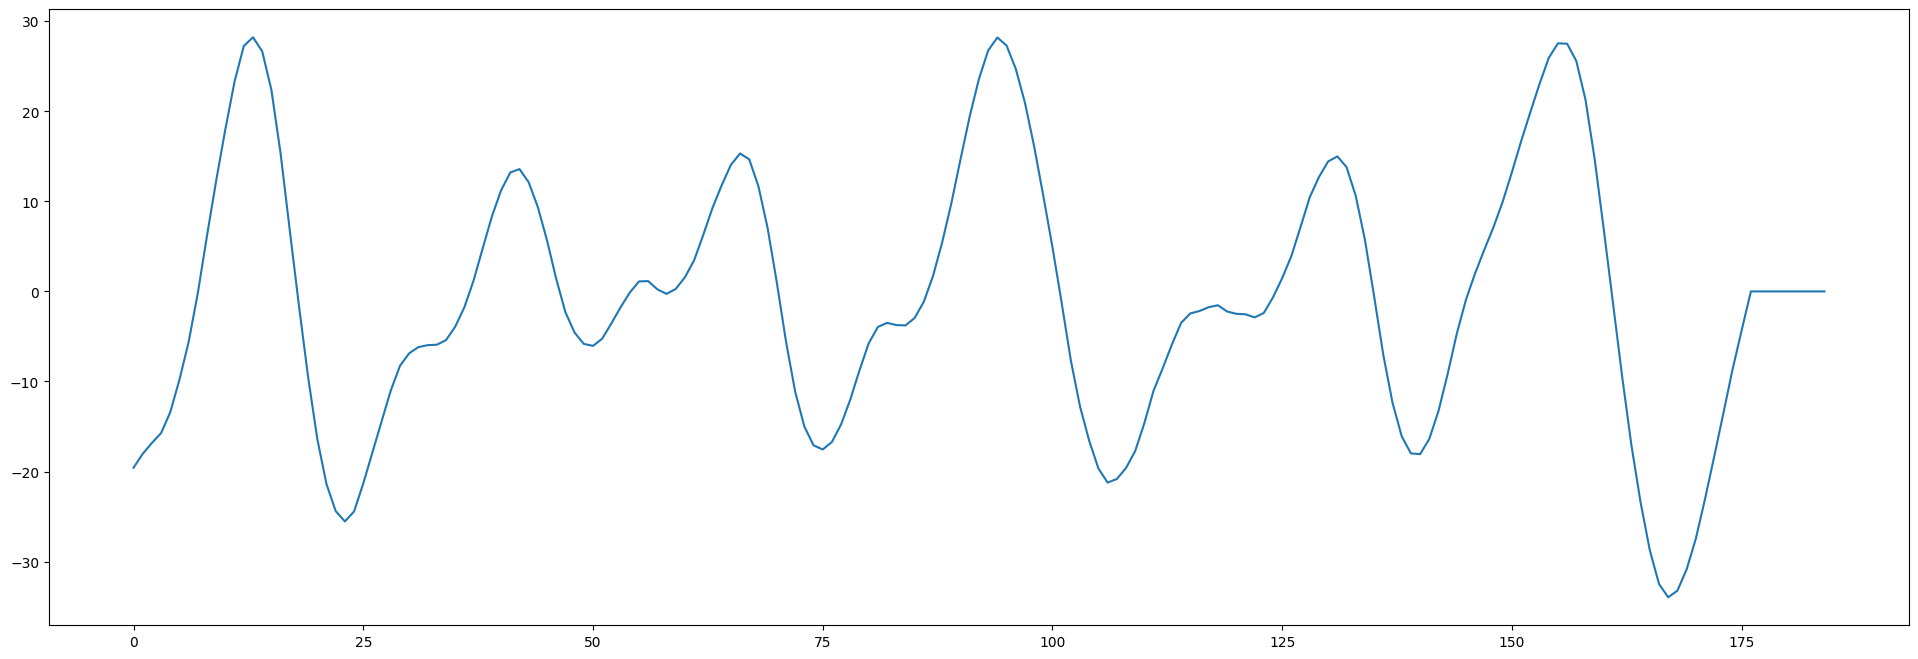

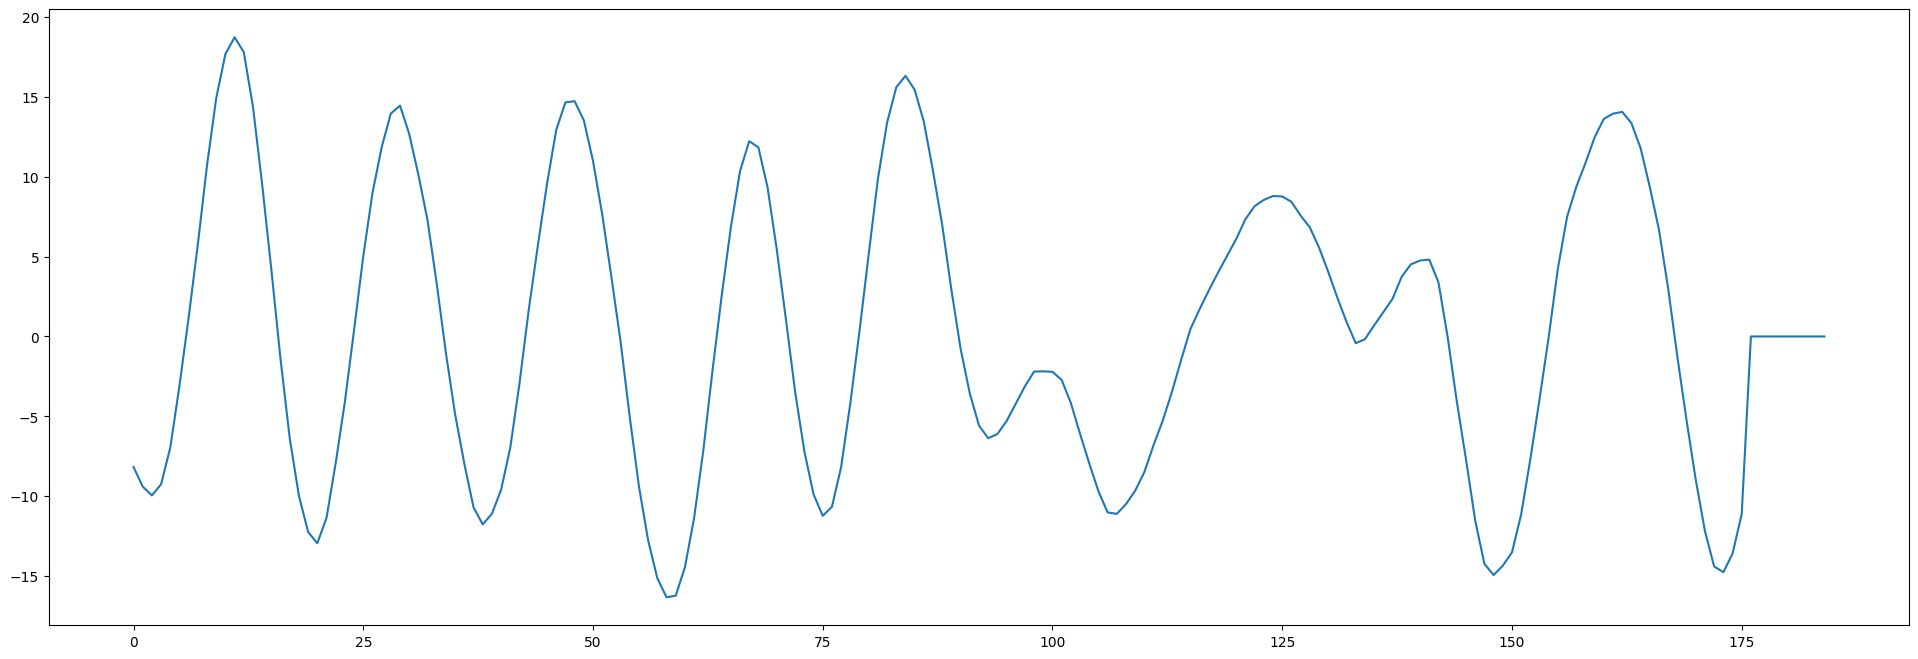

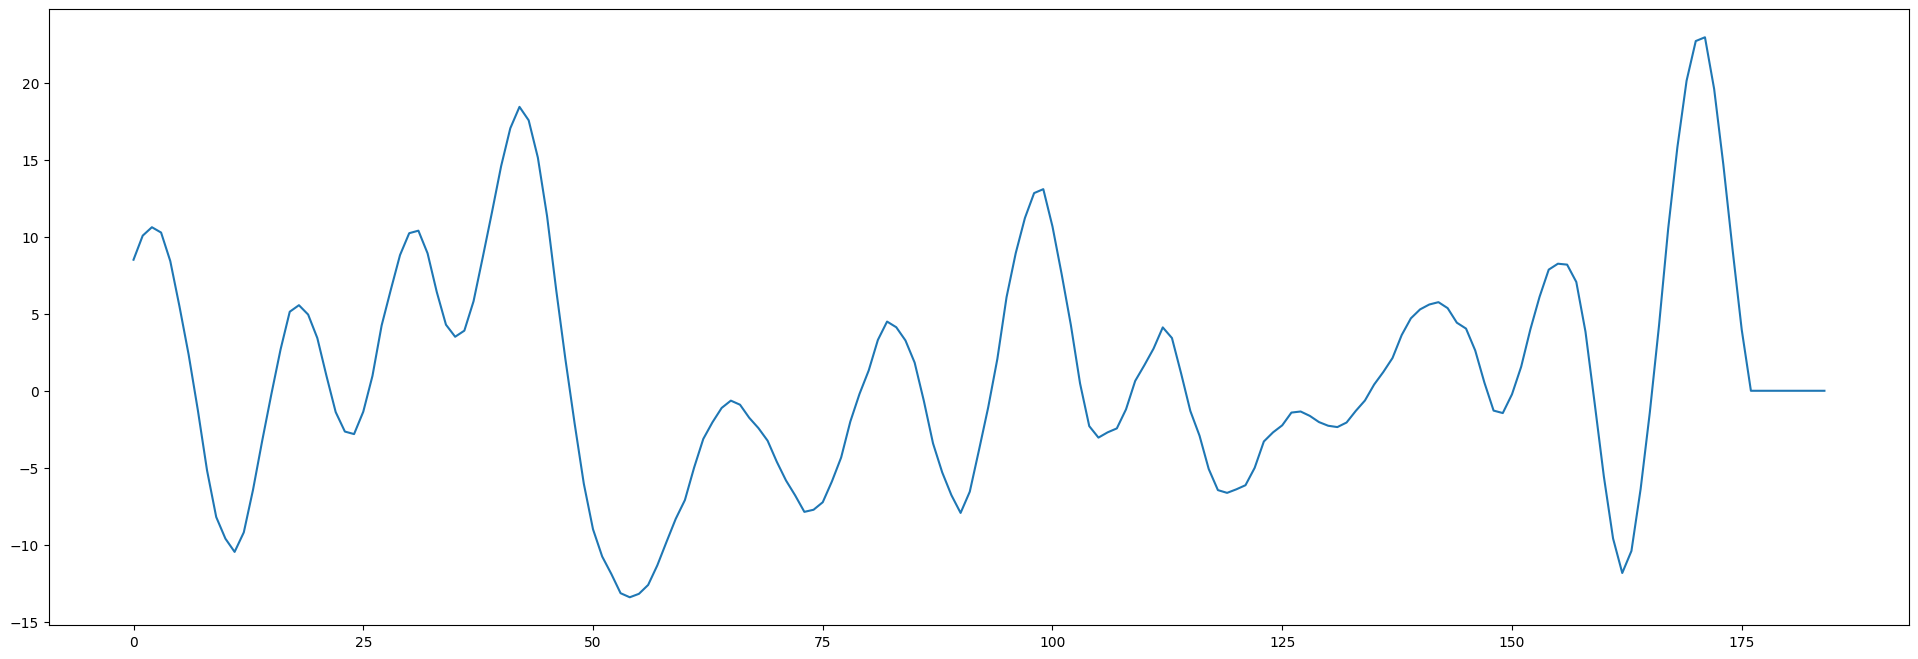

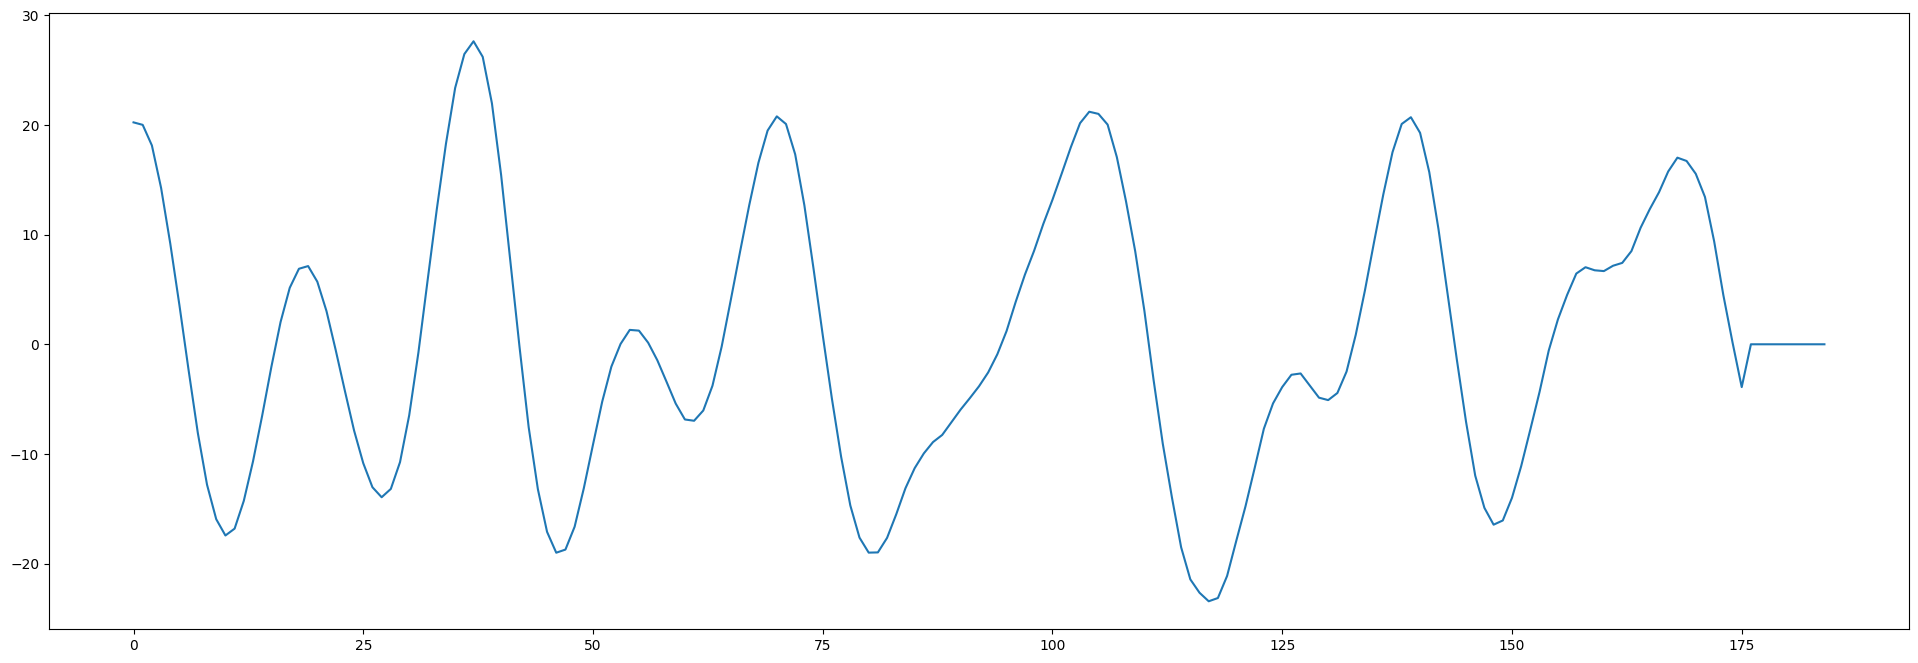

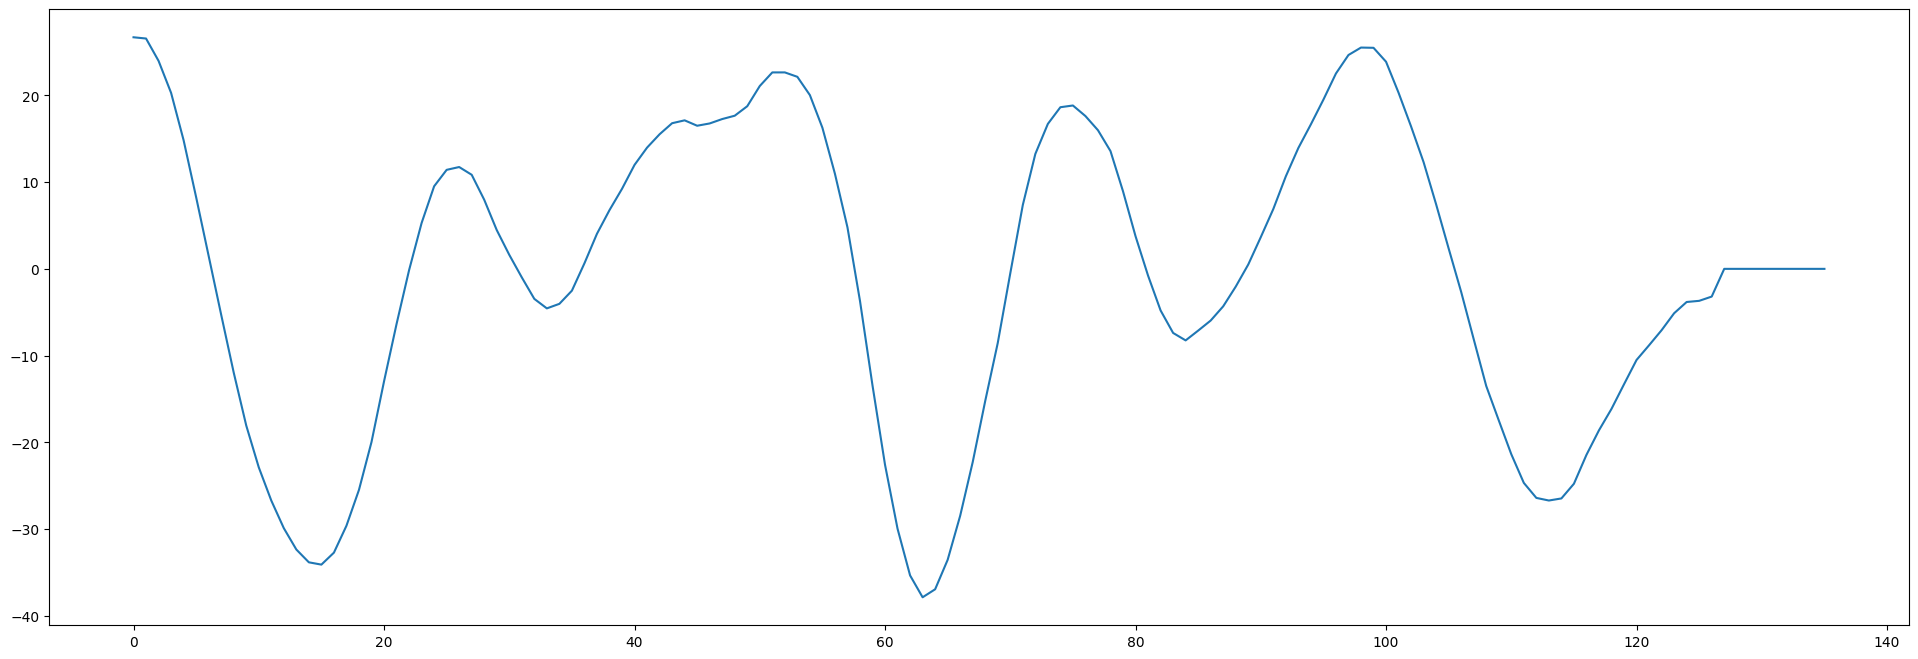

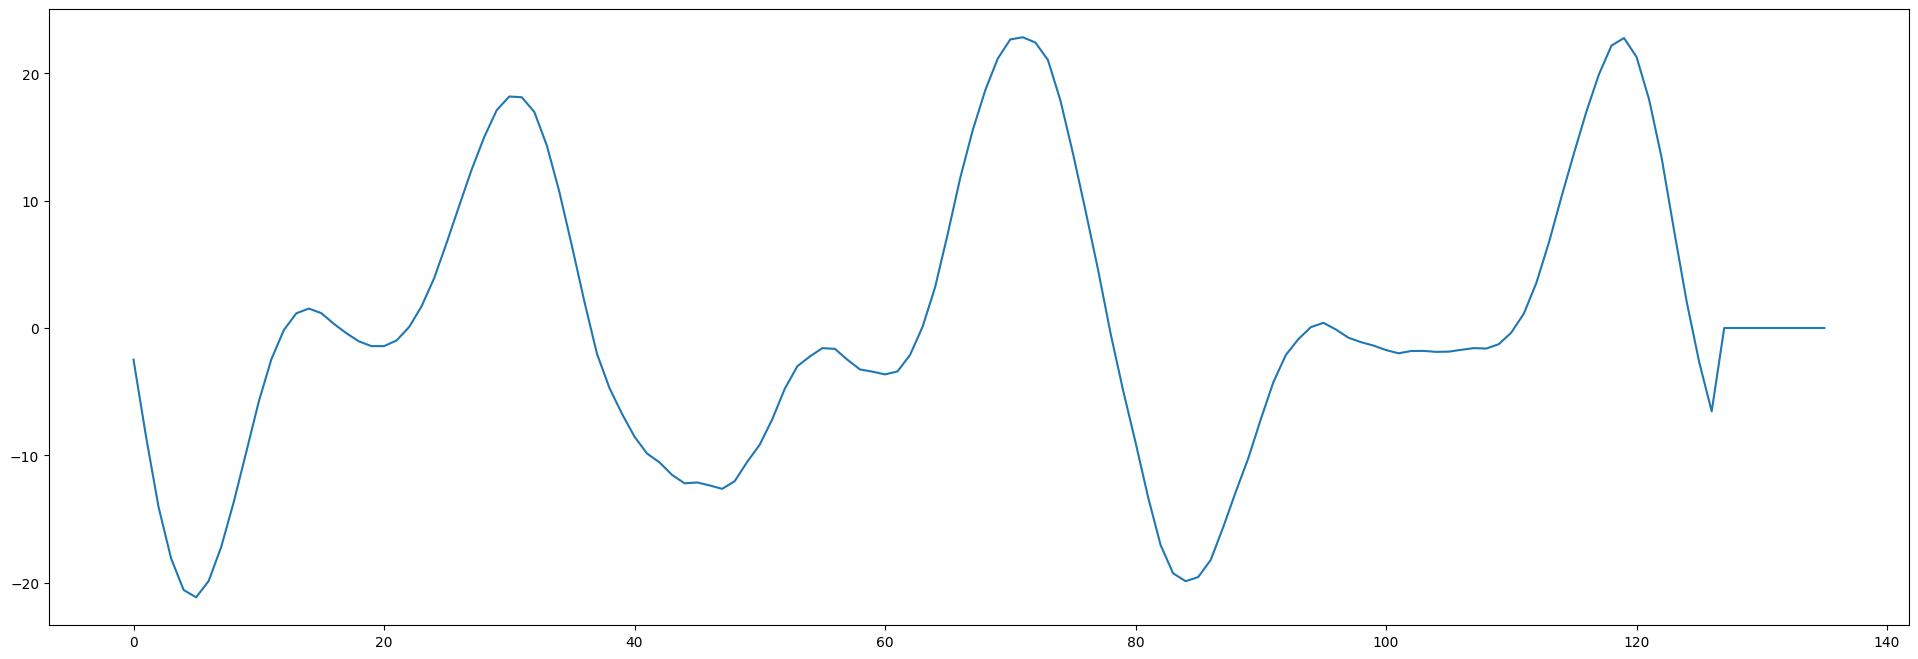

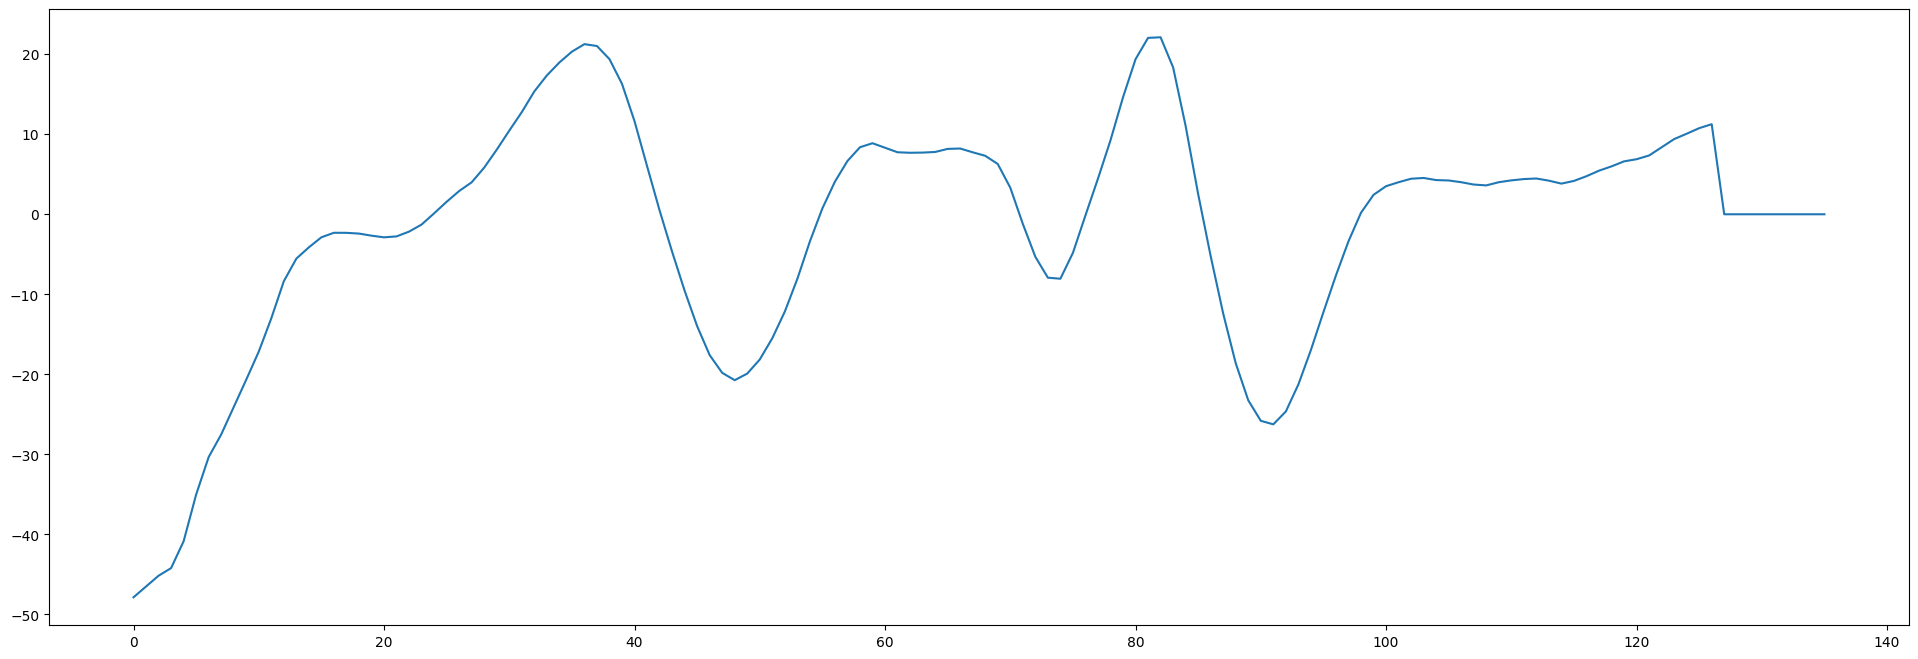

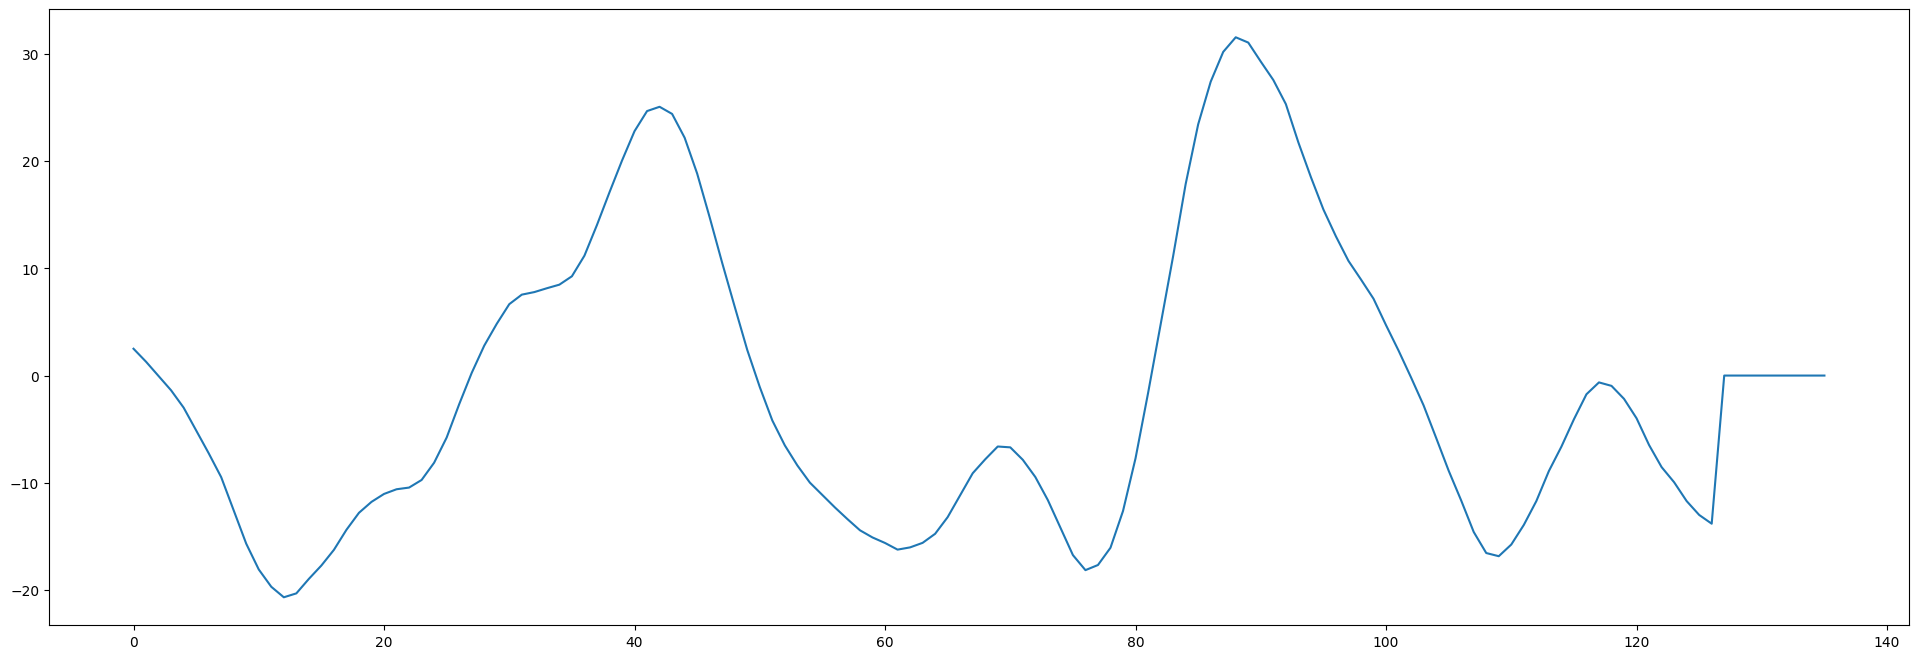

In [15]:
diff_rms_list = []                                                   ##全データのrms平均差分信号格納リスト

for index in range(len(wav_files)):
    rms_sample_num = rms_wave_list[index].shape[0]                   ##rms信号全体時間のの標本数
    rms_sample_rate = fs_rms_list[index]                             ##rms信号のサンプリング周波数
    second_sample = int(rms_sample_rate)                                ##rms信号の1秒間の標本数
    diff_rms = []                                                    ##rms信号の1秒間の平均差分信号
    
    for i in range(len(rms_wave_list[index])):
        
        ##最初の1秒以降
        if i+second_sample < len(rms_wave_list[index]):
            diff = rms_wave_list[index][i+second_sample]-rms_wave_list[index][i]
        ##最初の1秒以前
        else:
            diff = rms_wave_list[index][i]-rms_wave_list[index][i]
        diff_rms.append(diff)
    print(len(diff_rms))
    diff_rms_list.append(diff_rms)
    
for j in range(len(wav_files)):
    fig, ax = plt.subplots(figsize=(24, 8))
    plt.plot(diff_rms_list[j])

In [16]:
from scipy.signal import argrelmax,find_peaks

In [71]:
t_list = []
t = np.linspace(0.0, 15.0, 136)
data = np.array(rms_wave_list[0])

{'plateau_sizes': array([1, 1, 1, 1, 1, 1]), 'left_edges': array([ 15,  33,  55,  79,  91, 122]), 'right_edges': array([ 15,  33,  55,  79,  91, 122])}


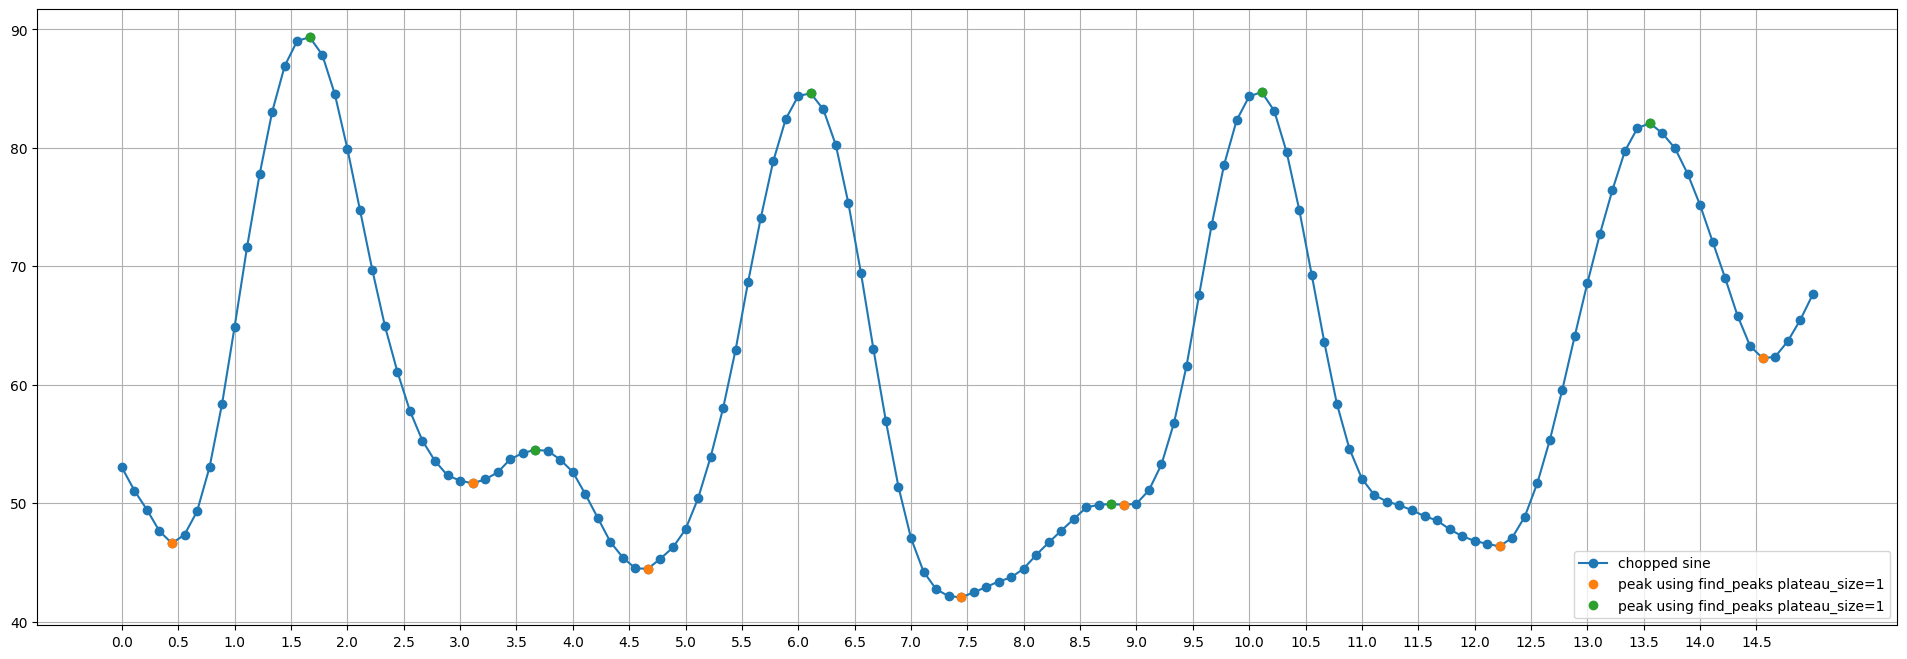

In [72]:
peaks_plateau1, properties_plateau1 = find_peaks(data, plateau_size=1)
peaks_plateau2, properties_plateau2 = find_peaks(-data, plateau_size=1)
#peaks_plateau10, properties_plateau10 = find_peaks(data, plateau_size=10)

plt.figure(figsize=(24,8))
plt.grid()
plt.plot(t, data, "o-", label="chopped sine")
plt.plot(t[peaks_plateau2], data[peaks_plateau2],"o",label="peak using find_peaks plateau_size=1")
plt.plot(t[peaks_plateau1], data[peaks_plateau1],"o",label="peak using find_peaks plateau_size=1")
plt.legend(loc="lower right")
print(properties_plateau1)
plt.xticks(np.arange(0, 15.0, 0.5))
plt.show()

In [73]:
peaks_plateau2

array([  4,  28,  42,  67,  80, 110, 131])

In [74]:
t[80]

8.88888888888889

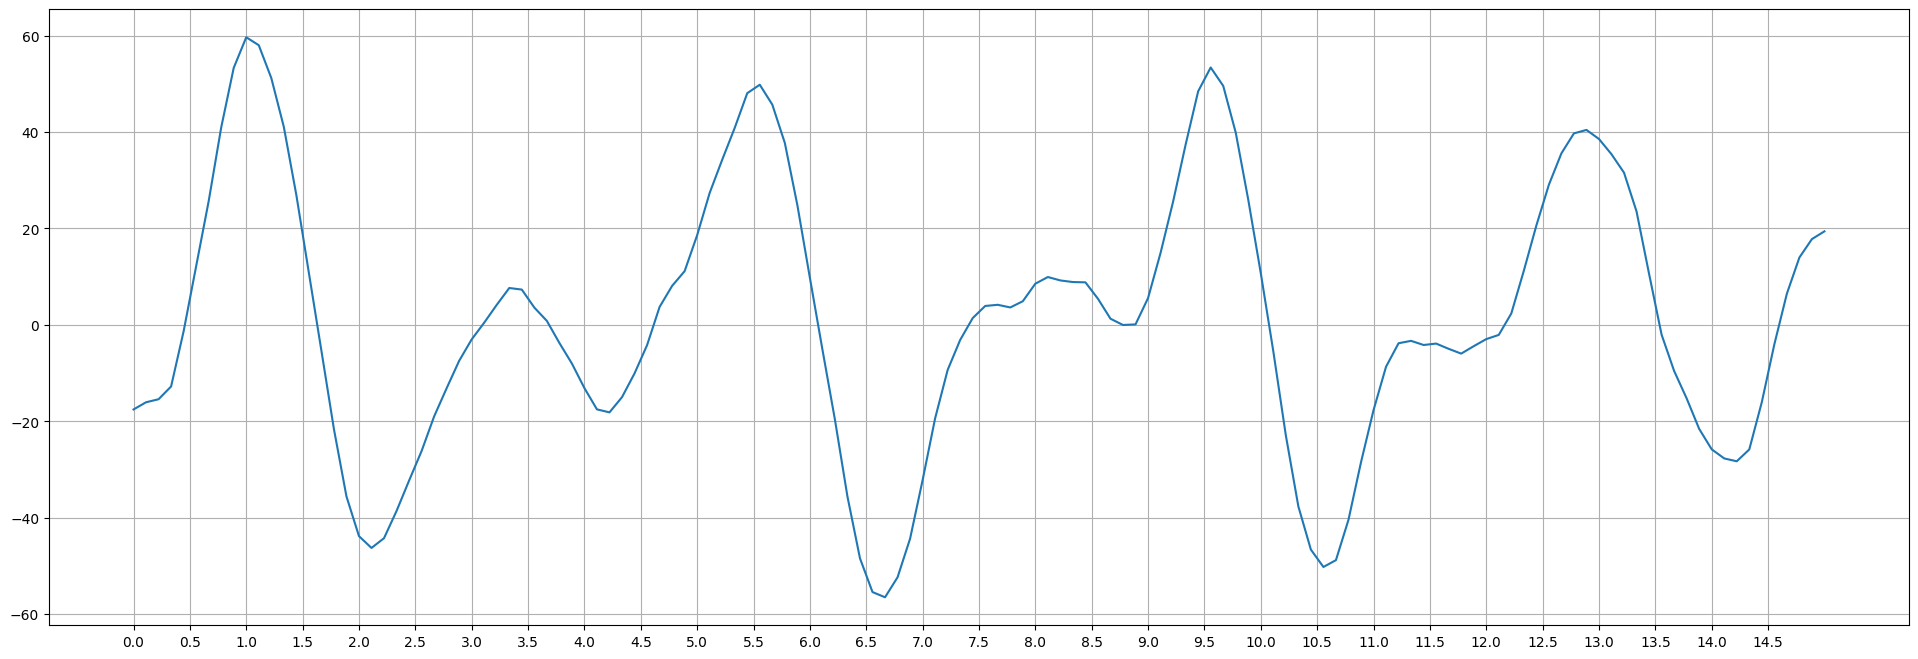

In [75]:
dx=np.gradient(t) #xの微小分
dy=np.gradient(data) #yの微小分
myu=dy/dx#各点の微分した値
plt.figure(figsize=(24,8))
plt.plot(t,myu)
plt.grid()
plt.xticks(np.arange(0, 15.0, 0.5))
plt.show()

{'plateau_sizes': array([1, 1, 1, 1, 1, 1, 1, 1, 1]), 'left_edges': array([  9,  30,  50,  69,  73,  86, 102, 104, 116]), 'right_edges': array([  9,  30,  50,  69,  73,  86, 102, 104, 116])}


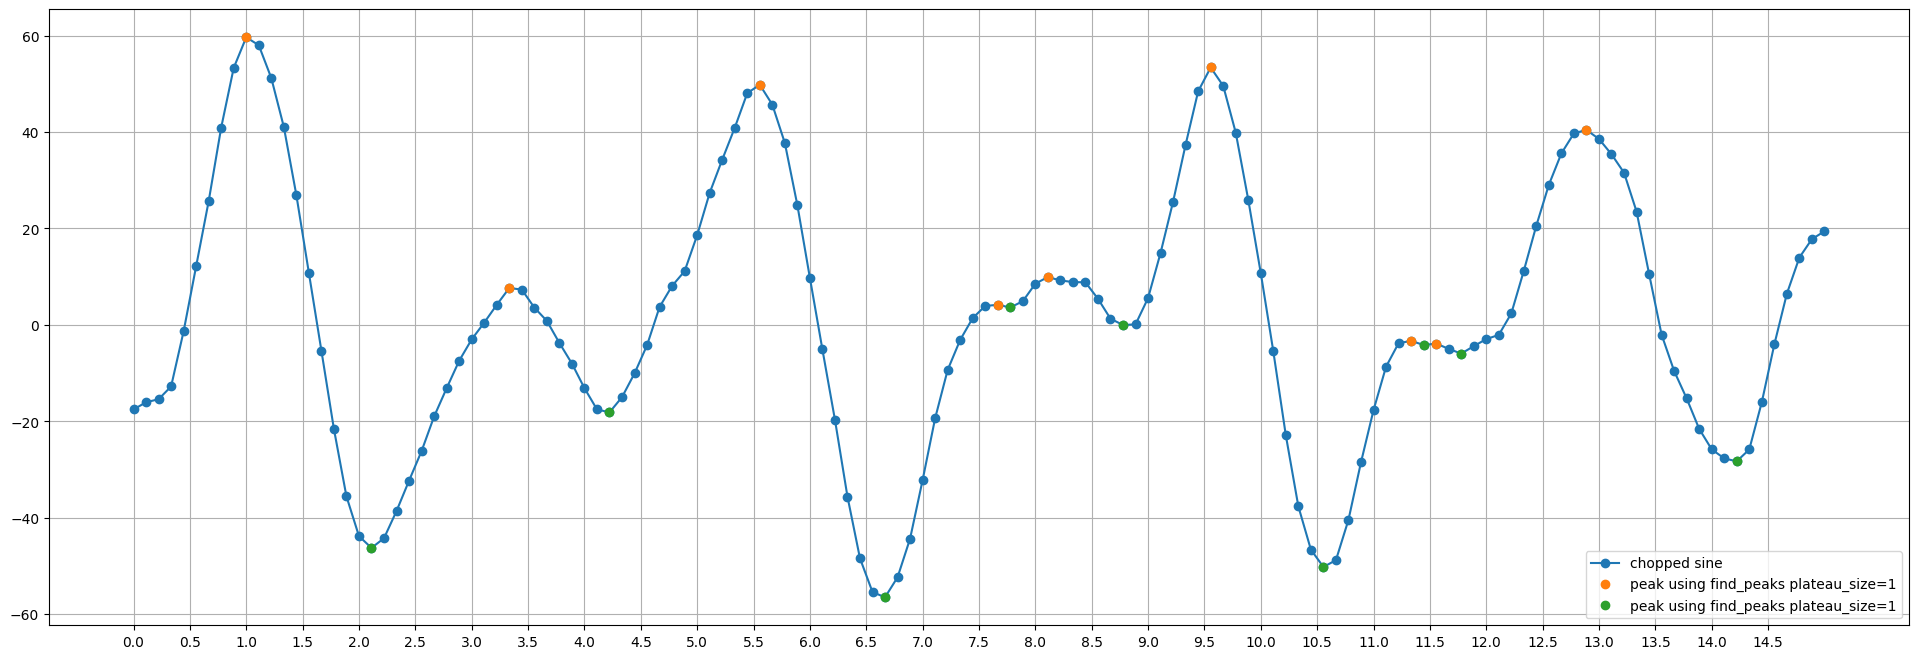

In [76]:
peaks_plateau3, properties_plateau3 = find_peaks(myu, plateau_size=1)
peaks_plateau4, properties_plateau4 = find_peaks(-myu, plateau_size=1)

plt.figure(figsize=(24,8))
plt.grid()
plt.plot(t, myu, "o-", label="chopped sine")
plt.plot(t[peaks_plateau3], myu[peaks_plateau3],"o",label="peak using find_peaks plateau_size=1")
plt.plot(t[peaks_plateau4], myu[peaks_plateau4],"o",label="peak using find_peaks plateau_size=1")
plt.legend(loc="lower right")
print(properties_plateau3)
plt.xticks(np.arange(0, 15.0, 0.5))
plt.show()

In [86]:
peaks_plateau3

array([  9,  30,  50,  69,  73,  86, 102, 104, 116])

In [82]:
peaks_plateau4

array([ 19,  38,  60,  70,  79,  95, 103, 106, 128])

In [88]:
peak_3 = np.array([])
flag = 0
temp = 0
ins = 0

for i in range(len(peaks_plateau3)):
    print(i)
    if i == len(peaks_plateau3)-1:
        peak_3 = np.append(peak_3, peaks_plateau3[i])
        break
        
    if t[peaks_plateau3[i+1]]-t[peaks_plateau3[i]]<=1.0:
            
        if flag == 0:
            temp_1 = t[peaks_plateau3[i]]
            flag = 1
            
        if t[peaks_plateau3[i+1]]-temp_1>1.0:
            index = peaks_plateau3[i+1]-temp_1//2
            flag = 0
            peak_3 = np.append(peak_3, index)
            ins = 1
    else:
        if ins == 0:
            peak_3 = np.append(peak_3, peaks_plateau3[i])
        ins = 0
        
peak_3

0
1
2
3
4
5
6
7
8


array([  9.,  30.,  50.,  73.,  86., 101., 116.])

In [ ]:
for i, value in enumerate(peaks_plateau4):
    temp = np.append(peaks_plateau3, value)
    temp = np.sort(temp)
    
    
    if myu[value]<=0:
        #print(myu[value])
        #print(value)
        for index, j in enumerate(temp):
            if j == value:
                prev_index = temp[index-1]
                next_index = temp[index+1]
        
        if -(myu[prev_index]-myu[value])>5 and -(myu[next_index]-myu[value])>5:
            print(prev_index)
            print(next_index)
            peaks_plateau1 = np.append(peaks_plateau1, value)
    
peaks_plateau1 = np.sort(peaks_plateau1)
peaks_plateau1

In [ ]:
plt.figure(figsize=(24,8))
plt.grid()
plt.plot(t, data, "o-", label="chopped sine")
plt.plot(t[peaks_plateau2], data[peaks_plateau2],"o",label="peak using find_peaks plateau_size=1")
plt.plot(t[peaks_plateau1], data[peaks_plateau1],"o",label="peak using find_peaks plateau_size=1")
plt.legend(loc="lower right")
print(properties_plateau1)
plt.xticks(np.arange(0, 15.0, 0.5))
plt.show()

In [ ]:
result = np.concatenate([peaks_plateau1, peaks_plateau2])
result = np.sort(result)
result

In [ ]:
breath_list = []
start_state = 0
s = 0

if s == 0:
    state = 1
elif s == 1:
    state = 0


for i in range(len(myu)):
    
    if s==len(result):
        breath_list.append(state)
        continue
    
    if t[i] < t[result[s]] and s == 0:
        breath_list.append(start_state)
        continue
        
    elif t[i] >= t[result[s]] and s == 0:
        
        if state == 0:
            state = 1
        elif state == 1:
            state = 0
            
        breath_list.append(state)
        s += 1 
        continue
        
        
    if t[i] < t[result[s]] and s != 0:
        breath_list.append(state)
        
    else:
        if state == 0:
            state = 1
        elif state == 1:
            state = 0
            
        breath_list.append(state)
        s += 1 

In [ ]:
ti = np.linspace(-0.5, 19.5, 185)
fig, ax = plt.subplots(figsize=(24, 8))
ax.set_xticks(np.arange(0.0, 20.0, 0.5))
plt.plot(ti,breath_list)

## 11/8
## 肺音の差分信号を用いたピーク検出による呼吸相識別
###  プログラム作成

過去に実施した、隠れマルコフモデルによる呼吸相識別と同様に信号抽出と精度検出するプログラムを作成  
信号はスペクトログラム画像から低周波信号のみを取り出して、平均化したものをベース信号として使用する  
ベース信号からRMS信号と差分信号を抽出し、信号の山と谷からピークを検出することで呼吸相を検出する  
本日の内容としてはピーク検出の実行部分を作成  
以後精度算出や精度向上のための前処理プログラムを引き続き作成する  
